# Pipeline for High-z Radio Galaxies 10: SHAP values for base models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the base-learners used for predictions.  
It is possible to select either a random sample from the predicted pipeline (non-star, radio AGN) or high-redshift sources,  
regardless of their predicted values.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

In [4]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = True
use_calibration     = True
use_high_z_sources  = False  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [5]:
used_area          = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset      = 'Test_Train'  # Validation, Training, Test, Test_Train
if not use_high_z_sources:
    if used_area == 'HETDEX':
        subset_str = f'_{HETDEX_subset}'
    if used_area != 'HETDEX':
        subset_str = ''
elif use_high_z_sources:
    subset_str     = ''

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Fint_VLAS82',\
                       'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                       'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                       'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Stotal_TGSS',\
                       'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                       'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [11]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

#### Select relevant sources

In [12]:
if use_high_z_sources:  # Only use high-z AGN
    # filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit)
    filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
    full_catalog_df    = full_catalog_df.loc[filter_selection]
    high_z_str         = '_high_z'
if not use_high_z_sources:
    high_z_str         = ''

In [13]:
if not use_high_z_sources:
    if used_area == 'HETDEX':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'is_AGN', use_calibration=use_calibration)
        print('Shape of used data in HETDEX')
        print('-' * 65)
        print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
        print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
        print(f'Training data:                                    {train_df.shape}')
        print(f'Testing data:                                     {test_df.shape}')
        if use_calibration:
            print(f'Calibration data:                                 {calibration_df.shape}')
        print(f'Validation data:                                  {validation_df.shape}')
        print('-' * 65)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                            'Validation': validation_df, 'Calibration': calibration_df}
        full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (83409, 94)
Data for Modeling (Train, Test, and Calibration): (66727, 94)
Training data:                                    (53381, 94)
Testing data:                                     (6673, 94)
Calibration data:                                 (6673, 94)
Validation data:                                  (16682, 94)
-----------------------------------------------------------------

Using Test_Train data from HETDEX


In [14]:
if not use_high_z_sources:
    if used_area != 'HETDEX':
        filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                           (full_catalog_df.loc[:, 'class'] == 1) |\
                           (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
        unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
        full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [15]:
full_catalog_df          = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [16]:
if not use_high_z_sources:
    if use_unknown:
        full_catalog_df = unknown_cat_df
    filter_selection   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

In [17]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')
print(f'From them, {np.sum(full_catalog_df.loc[:, "class"] == 1)} are confirmed AGN.')
print(f'From all the sources, {np.sum(full_catalog_df.loc[:, "LOFAR_detect"] == 1)} have radio (LOFAR-like) detection.')
print(f'From the {np.sum(full_catalog_df.loc[:, "class"] == 1)} AGN,\
 {np.sum((full_catalog_df.loc[:, "class"] == 1) & (full_catalog_df.loc[:, "LOFAR_detect"] == 1))} have radio (LOFAR-like) detection.')

Full used dataset size:              (66727, 90)
--------------------------------------------------
Thus, it has 66,727 sources and 90 features.
From them, 22601 are confirmed AGN.
From all the sources, 19482 have radio (LOFAR-like) detection.
From the 22601 AGN, 6721 have radio (LOFAR-like) detection.


### Load models

In [18]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [19]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.star_thresh  / (1 - gv.star_thresh))
threshold_AGN_logit      = np.log(gv.AGN_thresh   / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

#### Predictions

In [20]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [21]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [22]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [23]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [24]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [25]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on sub-set of base learners.

In [26]:
run_shap_AGN_base    = True
run_shap_radio_base  = True
run_shap_z_base      = True
run_shap_high_z_base = True

In [27]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [28]:
if run_shap_AGN_base:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [29]:
if run_shap_AGN_base:
    sample_size_AGN  = 1000
    sub_size_AGN     = np.nanmin([sample_size_AGN, np.sum(filter_pred_no_str)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 1,000


In [30]:
if run_shap_AGN_base:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [31]:
if run_shap_AGN_base:
    reduced_data_AGN    = full_catalog_df.loc[filter_pred_no_str].sample(n=sub_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns.drop(base_models_names_AGN)

class  pred_class
count  1000.000000  1000.00000
mean      0.374000     0.37800
std       0.484106     0.48513
min       0.000000     0.00000
25%       0.000000     0.00000
50%       0.000000     0.00000
75%       1.000000     1.00000
max       1.000000     1.00000

Use FastTreeSHAP package

In [32]:
if run_shap_AGN_base:
    explainers_AGN_base = {}
    for model, model_fit in zip(AGN_gal_clf.named_steps['trained_model'].estimators, AGN_gal_clf.named_steps['trained_model'].estimators_):
        explainers_AGN_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',
                                                                   model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                   n_jobs=12)  # No data

In [33]:
if run_shap_AGN_base:
    shap_values_AGN_base  = {}
    for model in explainers_AGN_base.keys():
        print(f'Working with base model {model}')
        shap_values_AGN_base[model] = explainers_AGN_base[model](reduced_data_AGN_df.drop(columns=base_models_names_AGN), check_additivity=False)

Working with base model xgboost
Working with base model et
Working with base model rf
Working with base model gbc


In [34]:
if run_shap_AGN_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_AGN_base.keys():
        expected_value = np.array([explainers_AGN_base[model].expected_value]).flatten()[-1]
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            print(f'{model: <10}\t: {np.exp(expected_value) / (1 + np.exp(expected_value)): .4f}')
        else:
            print(f'{model: <10}\t: {expected_value: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	:  0.2329
et        	:  0.3387
rf        	:  0.3388
gbc       	:  0.2037


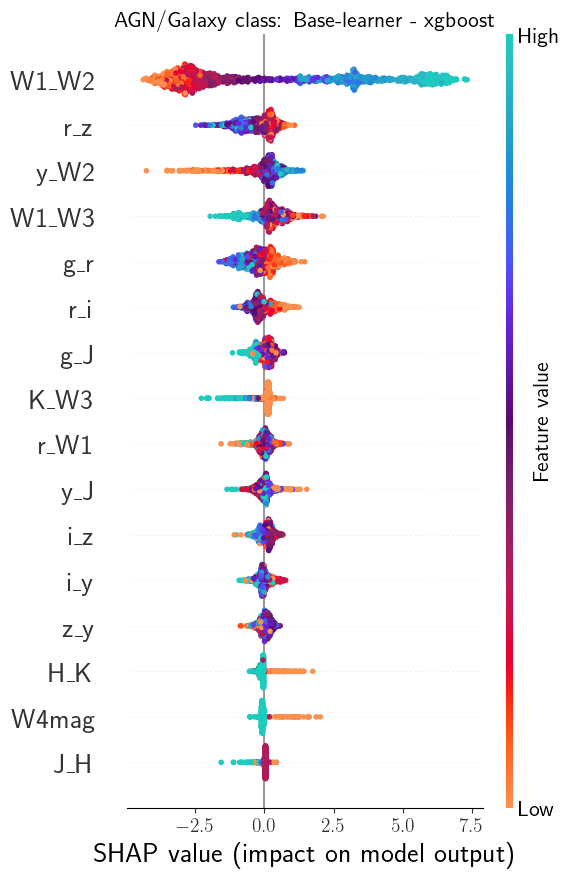

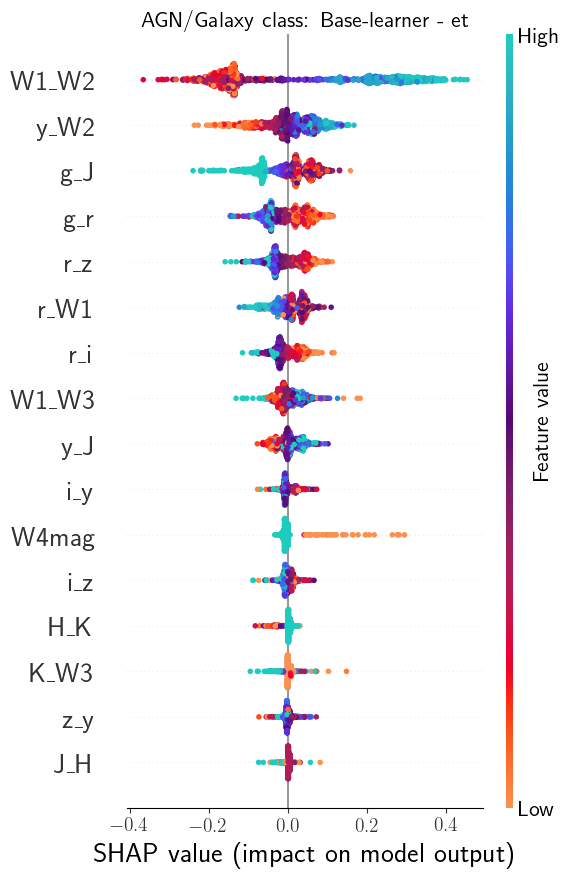

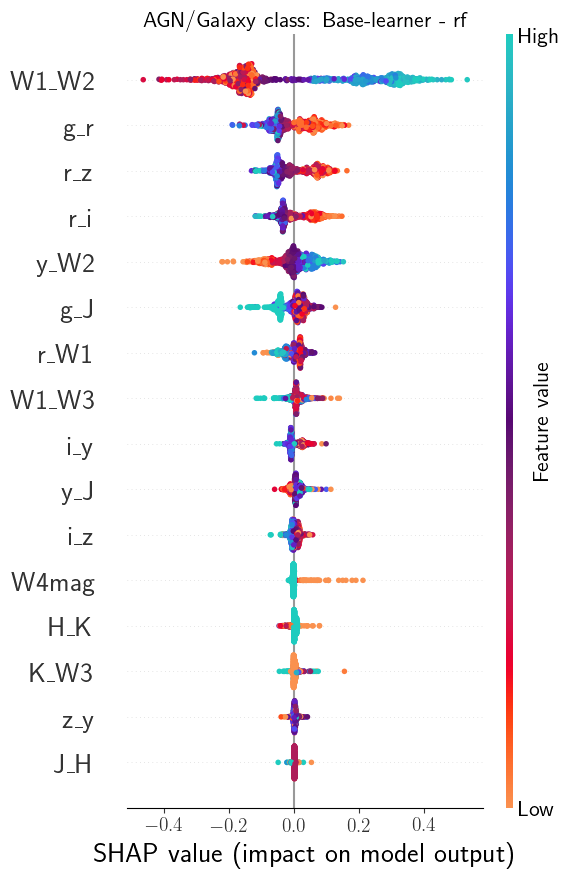

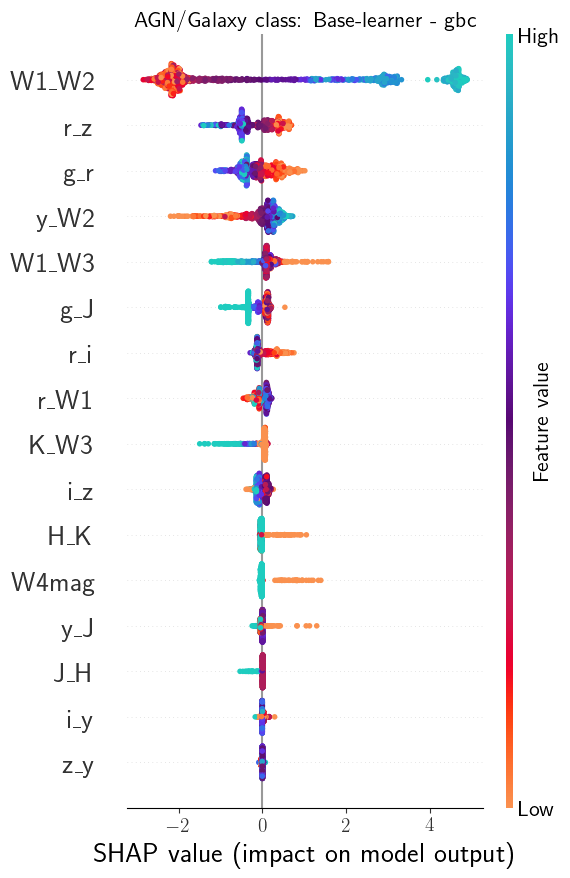

In [35]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        gf.plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_AGN_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [36]:
# new_base_logit_AGN = np.log(gv.cal_AGN_thresh / (1 - gv.cal_AGN_thresh))
new_base_logit_AGN = np.log(0.5 / (1 - 0.5))

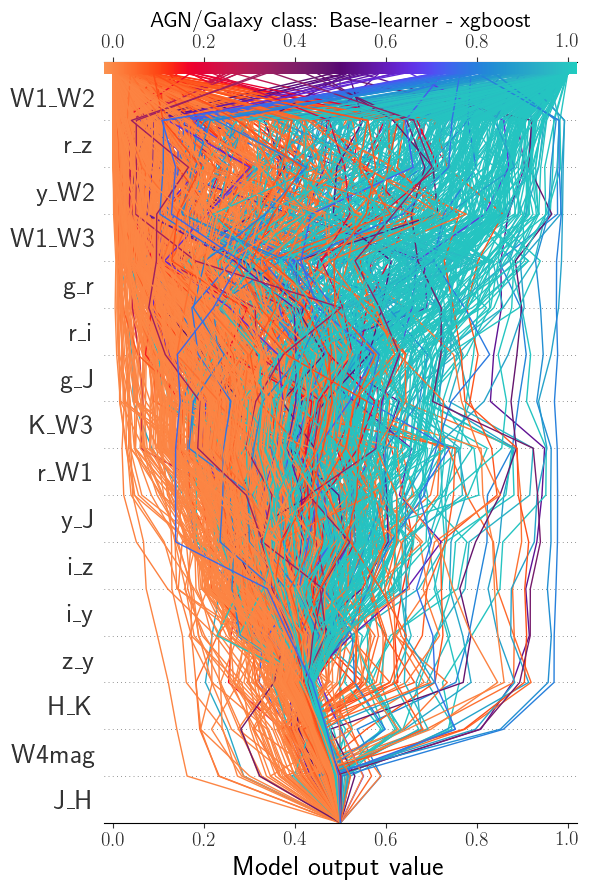

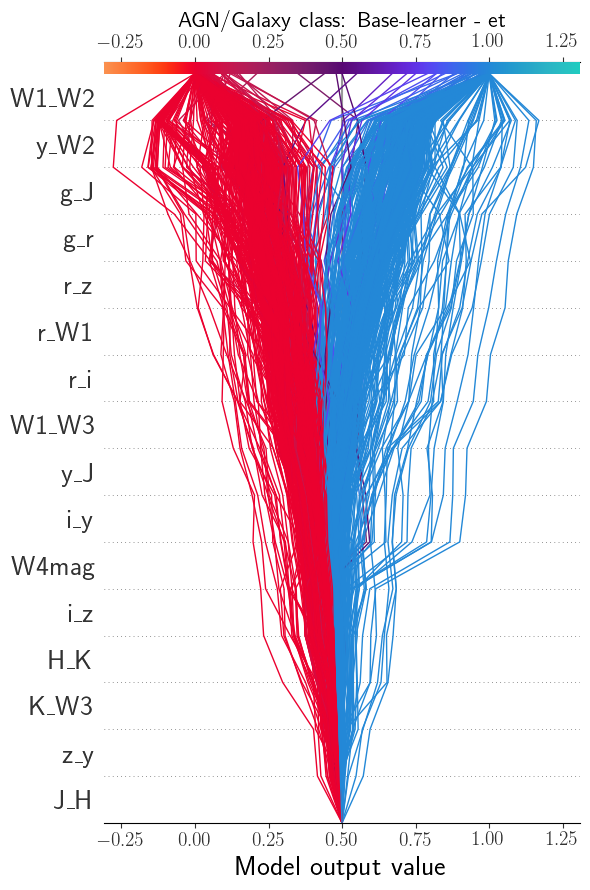

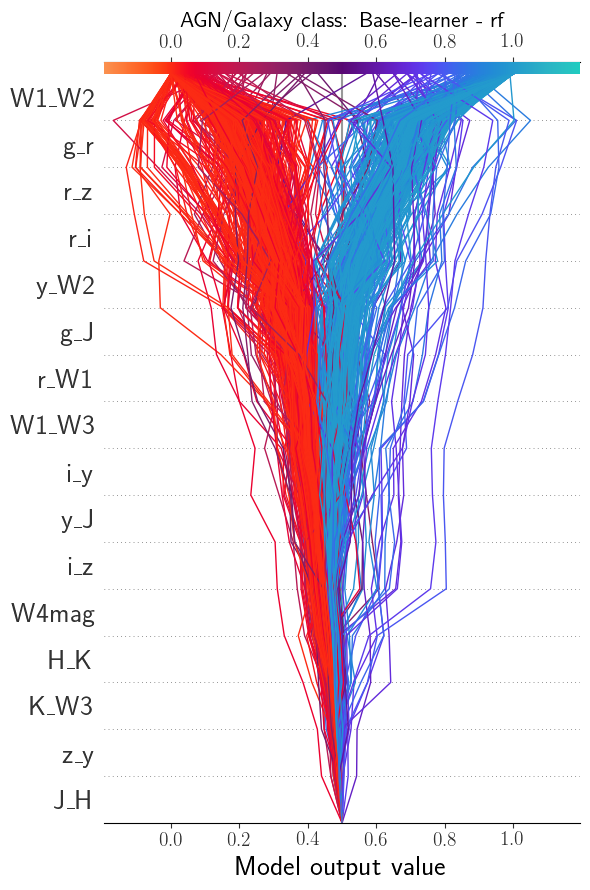

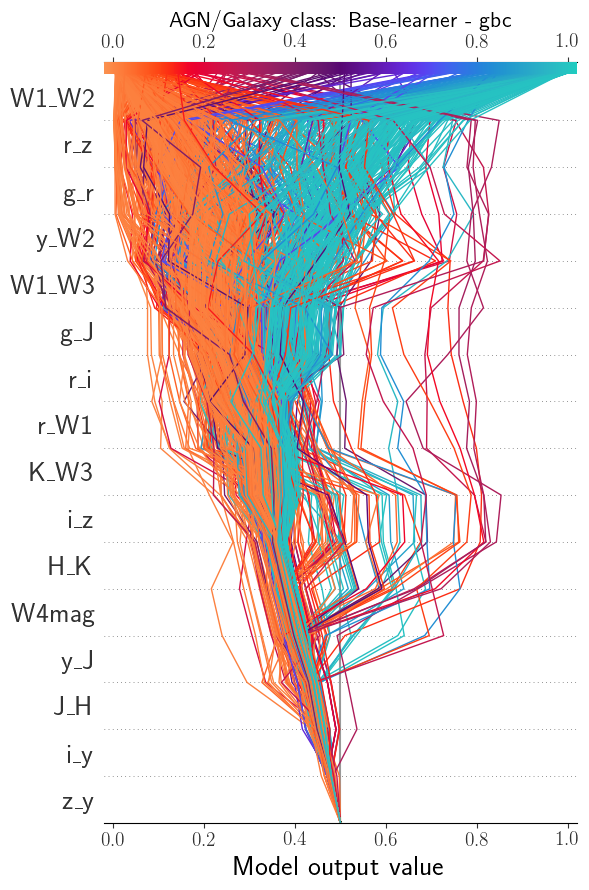

In [37]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        size_side        = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode   = 'logit'
            new_base_AGN = new_base_logit_AGN
        else:
            logit_mode   = 'identity'
            # new_base_AGN = gv.cal_AGN_thresh
            new_base_AGN = 0.5
        fig              = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model], explainers_AGN_base[model],\
                           reduced_cols_AGN, ax1, logit_mode, new_base_value=new_base_AGN, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_AGN_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [38]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN = gf.mean_abs_SHAP_base_models(shap_values_AGN_base, list(shap_values_AGN_base.keys()))
    for key in shap_values_AGN_base.keys():
        sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                sorted_mean_abs_SHAP_AGN[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_AGN = [(key, name) for key in sorted_mean_abs_SHAP_AGN.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [39]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN_base_full_df = pd.concat([sorted_mean_abs_SHAP_AGN[key].reset_index(drop=True) for key in shap_values_AGN_base.keys()], axis=1)
    sorted_mean_abs_SHAP_AGN_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_AGN)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN_base_full_df)

Mean absolute SHAP values scaled to sum 100


xgboost                    et                    rf                   gbc  \
   Feature Mean_abs_SHAP Feature Mean_abs_SHAP Feature Mean_abs_SHAP Feature   
0    W1_W2        45.384   W1_W2        36.900   W1_W2        38.685   W1_W2   
1      r_z         7.074    y_W2         9.587     g_r        10.790     r_z   
2     y_W2         6.887     g_J         9.436     r_z        10.268     g_r   
3    W1_W3         6.843     g_r         7.863     r_i         8.542    y_W2   
4      g_r         5.941     r_z         6.675    y_W2         7.903   W1_W3   
5      r_i         4.396    r_W1         5.431     g_J         5.468     g_J   
6      g_J         3.238     r_i         4.842    r_W1         3.942     r_i   
7     K_W3         3.031   W1_W3         4.446   W1_W3         3.076    r_W1   
8     r_W1         2.740     y_J         4.206     i_y         3.042    K_W3   
9      y_J         2.668     i_y         2.110     y_J         2.312     i_z   
10     i_z         2.621   W4mag         2.055     i_z         1.888     H_K   
11     i_y         2.486     i_z         1.765   W4mag         1.102   W4mag   
12     z_y         2.158     H_K         1.518     H_K         1.096     y_J   
13     H_K         2.003    K_W3         1.250    K_W3         0.867     J_H   
14   W4mag         1.592     z_y         1.101     z_y         0.700     i_y   
15     J_H         0.939     J_H         0.814     J_H         0.319     z_y   

                  
   Mean_abs_SHAP  
0         53.540  
1          8.443  
2          7.307  
3          6.740  
4          5.724  
5          3.840  
6          3.612  
7          2.465  
8          2.379  
9          2.176  
10         1.134  
11         1.100  
12         0.720  
13         0.349  
14         0.342  
15         0.130

In [40]:
if run_shap_AGN_base:
    sorted_mean_abs_SHAP_AGN = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_AGN_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [99]:
if run_shap_AGN_base:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN.copy().set_index('Feature')
    for key in shap_values_AGN_base.keys():
        factor = sorted_mean_abs_SHAP_AGN.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_AGN_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_AGN_comb = sorted_mean_abs_SHAP_AGN_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                              ascending=False).drop(index=list(shap_values_AGN_base.keys()))
    sorted_mean_abs_SHAP_AGN_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_AGN_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_AGN_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                               
W1_W2           36.421          36.421
g_r              9.038          45.458
y_W2             8.533          53.992
r_z              6.927          60.919
r_i              6.000          66.920
W1_W3            5.936          72.856
g_J              5.522          78.378
r_W1             3.918          82.295
K_W3             3.234          85.529
i_z              2.636          88.165
y_J              2.465          90.630
i_y              2.436          93.066
z_y              2.200          95.266
J_H              1.655          96.921
H_K              1.615          98.536
W4mag            1.464         100.000

xgboost


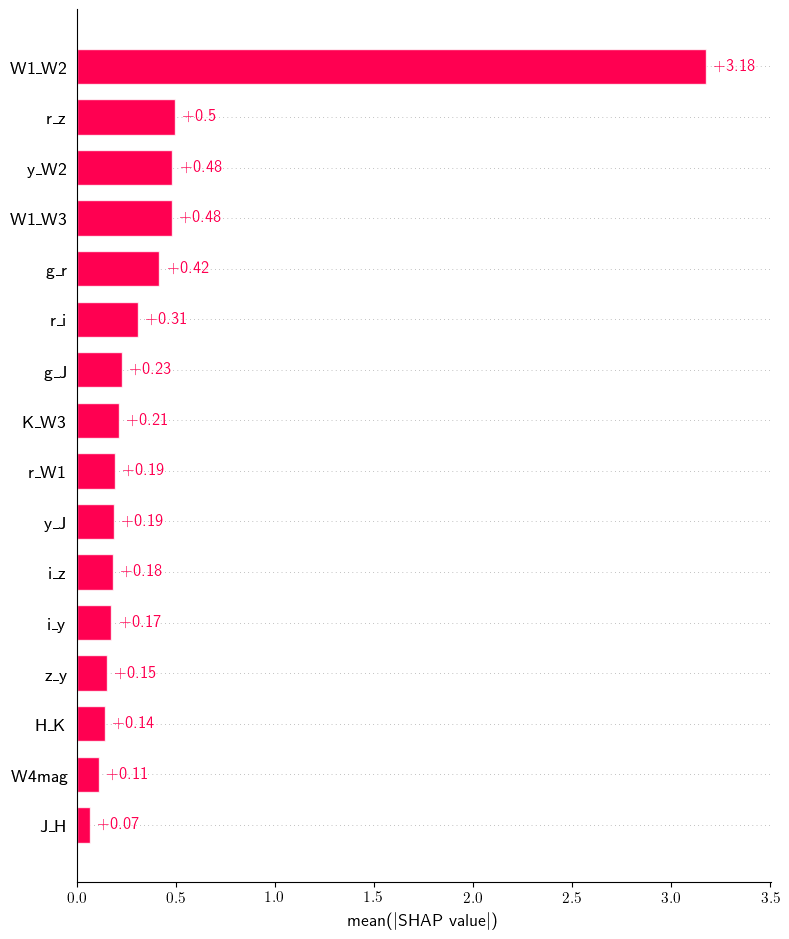

et


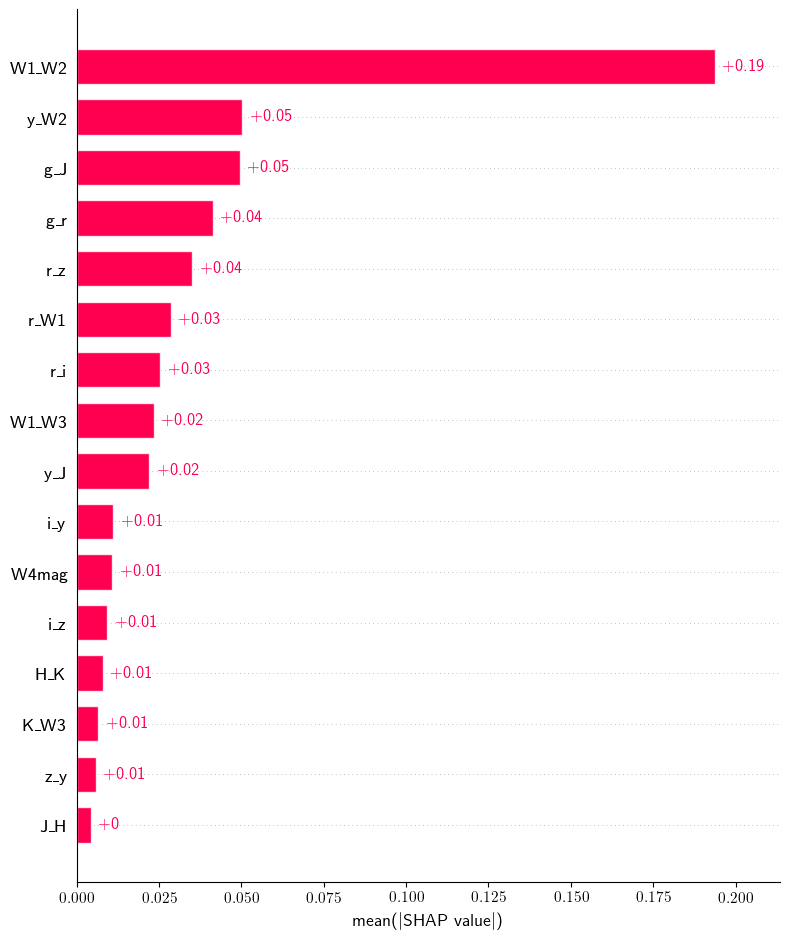

rf


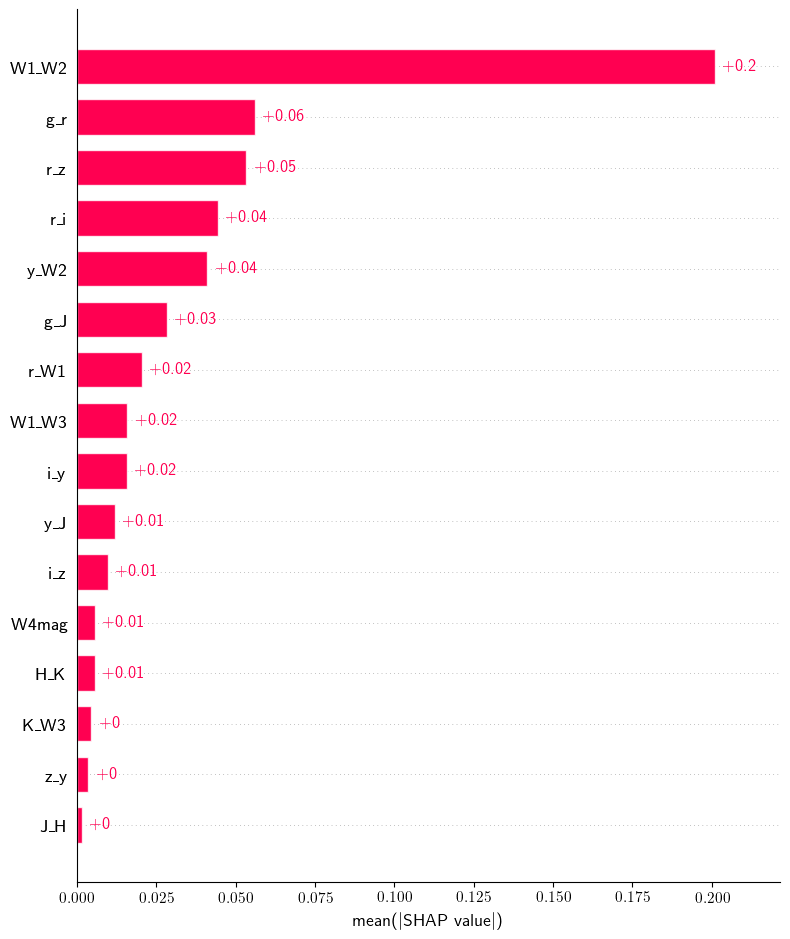

gbc


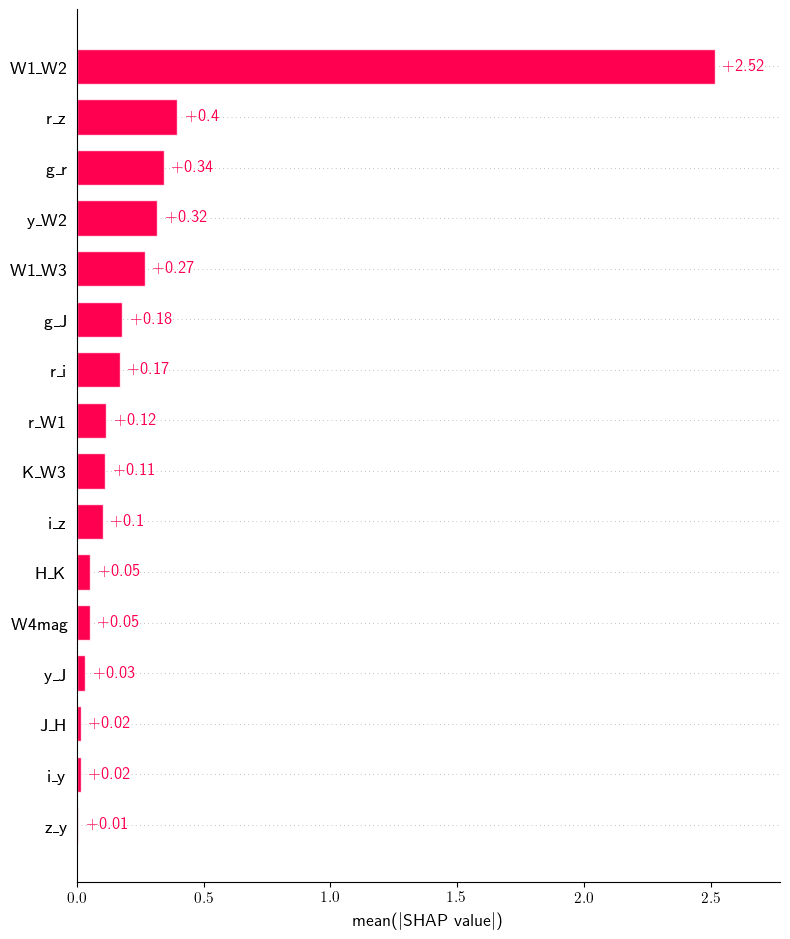

In [42]:
if run_shap_AGN_base:
    shp_copies_AGN = {}
    for model in shap_values_AGN_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_AGN[model] = shap.Explanation(values=shap_values_AGN_base[model].values,\
                                                 base_values=shap_values_AGN_base[model].base_values,\
                                                 data=shap_values_AGN_base[model].data,\
                                                 feature_names=shap_values_AGN_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_AGN[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model], max_display=None, show=False)
        elif np.ndim(shp_copies_AGN[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

xgboost


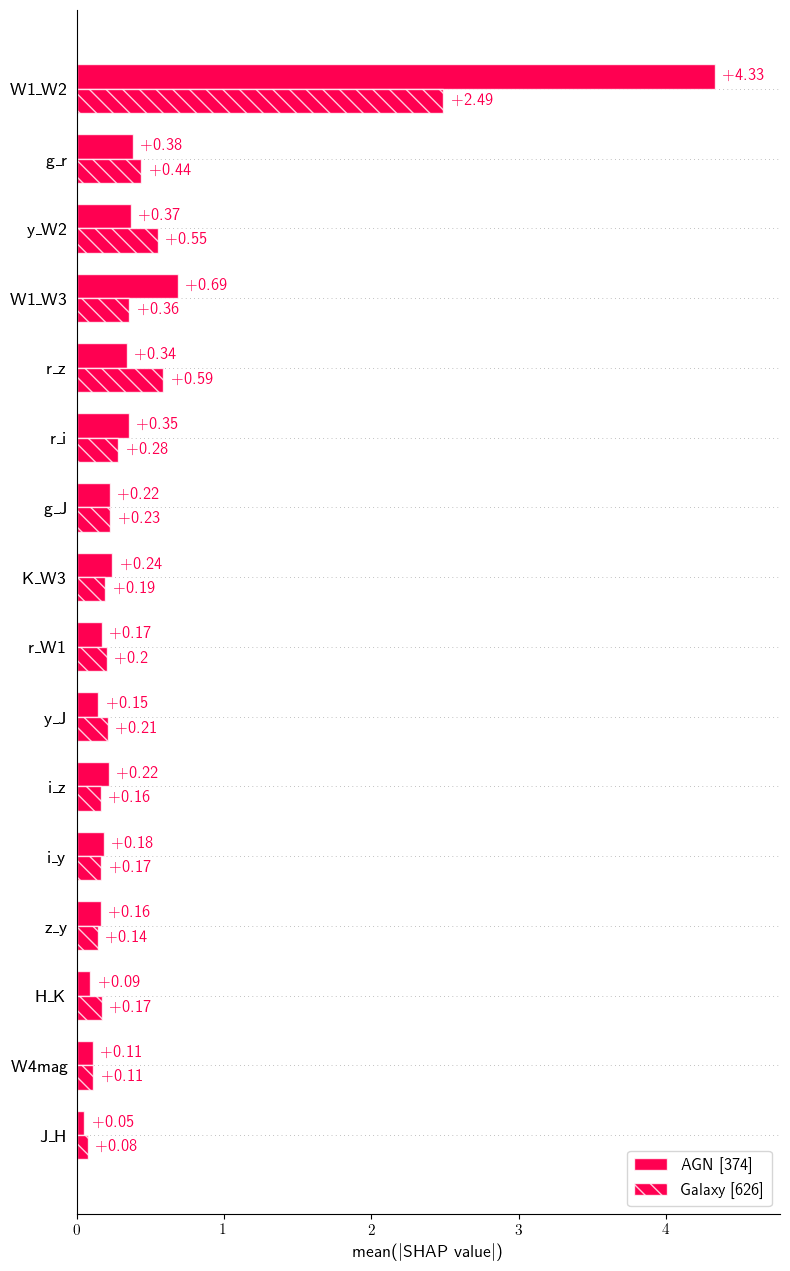

et


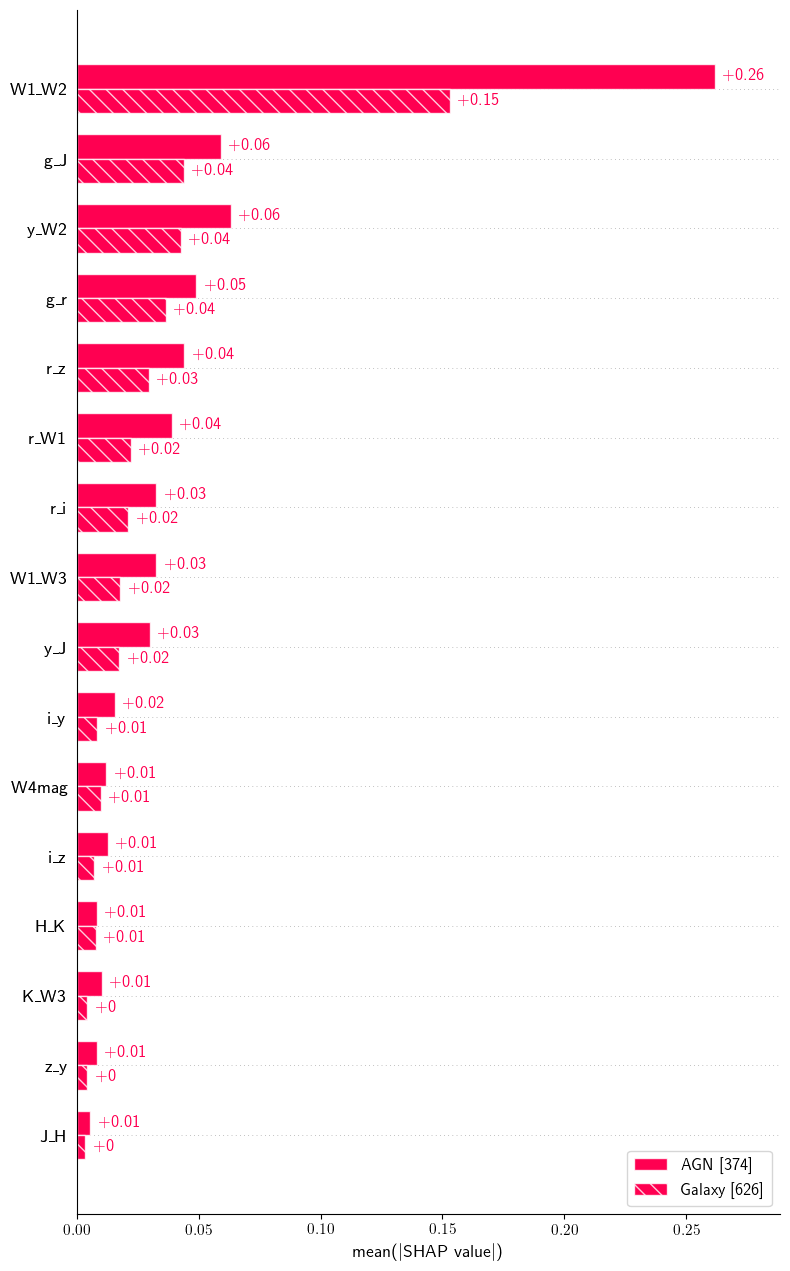

rf


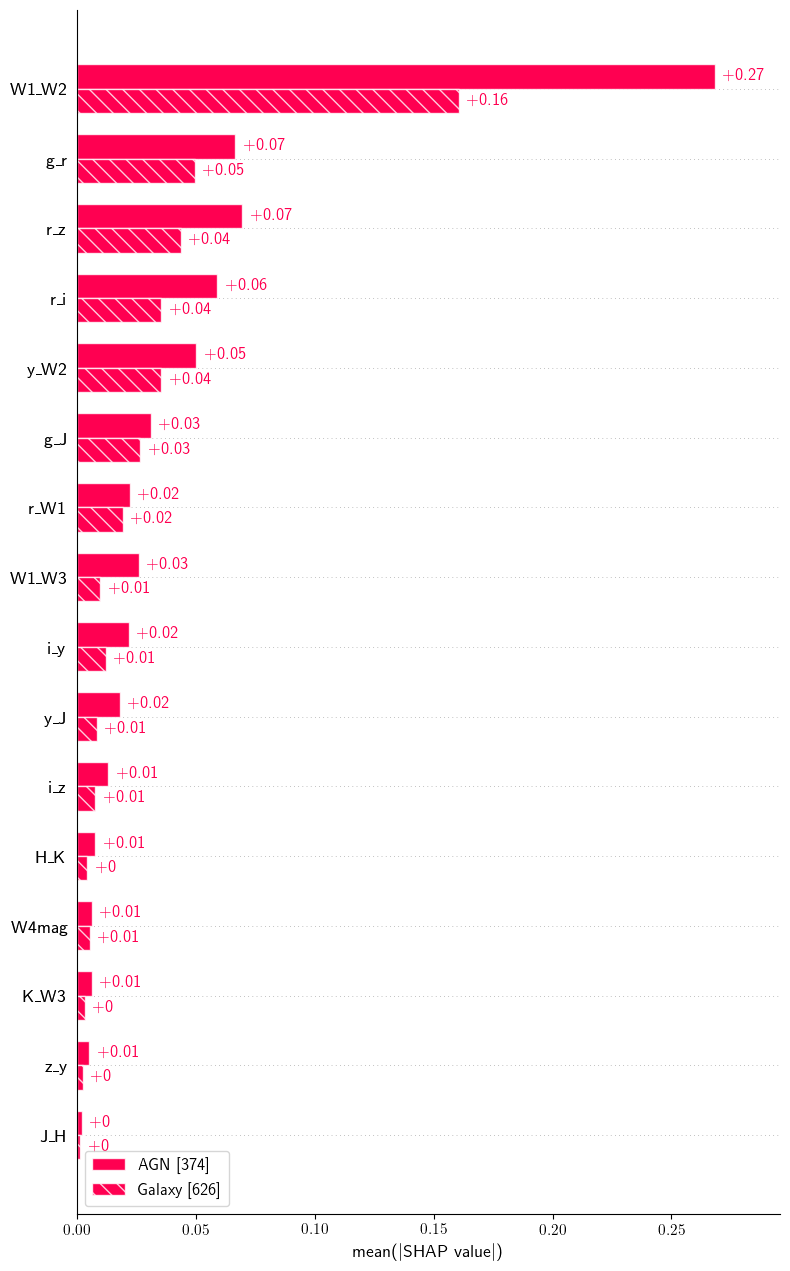

gbc


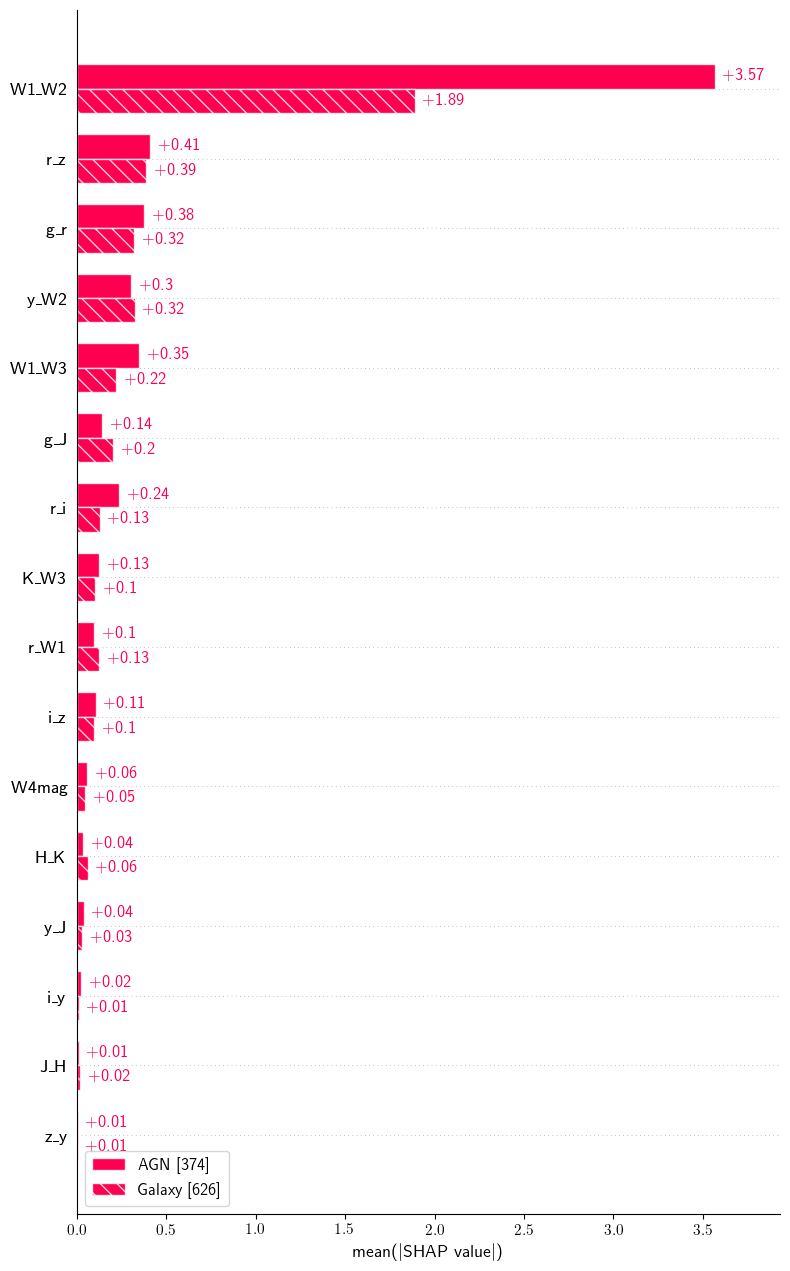

In [43]:
if run_shap_AGN_base:
    class_AGN_labels = ['Galaxy' if elem == 0 else 'AGN' for elem in reduced_data_AGN.loc[:, 'class']]
    for model in shap_values_AGN_base.keys():
        print(f'{model}')
        if np.ndim(shp_copies_AGN[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model].cohorts(class_AGN_labels).abs.mean(0), max_display=None, show=False)
        elif np.ndim(shp_copies_AGN[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model][:, :, 1].cohorts(class_AGN_labels).abs.mean(0), max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [44]:
if run_shap_AGN_base:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=base_models_names_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_AGN_base[model].expected_value]).flatten()[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))


xgboost:
0
-6.15348

et:
0
0.33872

rf:
0
0.33878

gbc:
0
-3.15989


---

#### SHAP - Radio detection model

In [45]:
if run_shap_radio_base:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [46]:
if run_shap_radio_base:
    sample_size_radio   = 1000
    if not use_high_z_sources:
        filter_pred_AGN = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    if use_high_z_sources:
        filter_pred_AGN   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_radio   = np.nanmin([sample_size_radio, np.sum(filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 1,000


In [47]:
if run_shap_radio_base:
    base_models_name_radio   = gf.get_base_estimators_names(radio_det_clf)

In [48]:
if run_shap_radio_base:
    reduced_data_radio    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio.loc[:, ['LOFAR_detect', 'pred_radio']].describe())
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_name_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns.drop(base_models_name_radio)

LOFAR_detect  pred_radio
count   1000.000000  1000.00000
mean       0.289000     0.25600
std        0.453525     0.43664
min        0.000000     0.00000
25%        0.000000     0.00000
50%        0.000000     0.00000
75%        1.000000     1.00000
max        1.000000     1.00000

Use FastTreeSHAP package

In [49]:
if run_shap_radio_base:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                     n_jobs=12)

In [50]:
if run_shap_radio_base:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=base_models_name_radio))

Working with base model xgboost
Working with base model rf
Working with base model et
Working with base model gbc


In [51]:
if run_shap_radio_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        expected_value = np.array([explainers_radio_base[model].expected_value]).flatten()[-1]
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            print(f'{model: <10}\t: {np.exp(expected_value) / (1 + np.exp(expected_value)): .4f}')
        else:
            print(f'{model: <10}\t: {expected_value: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	:  0.2704
rf        	:  0.2990
et        	:  0.2992
gbc       	:  0.2604


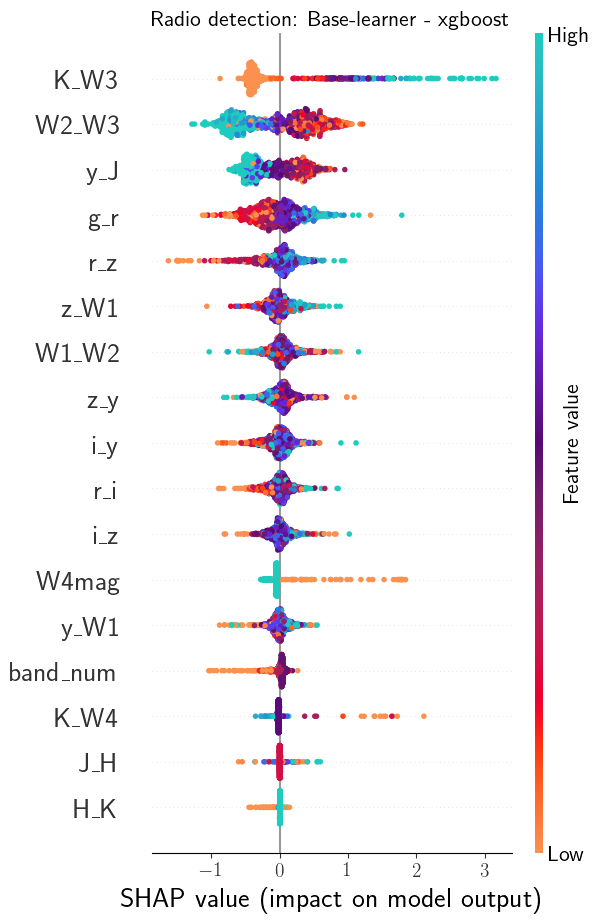

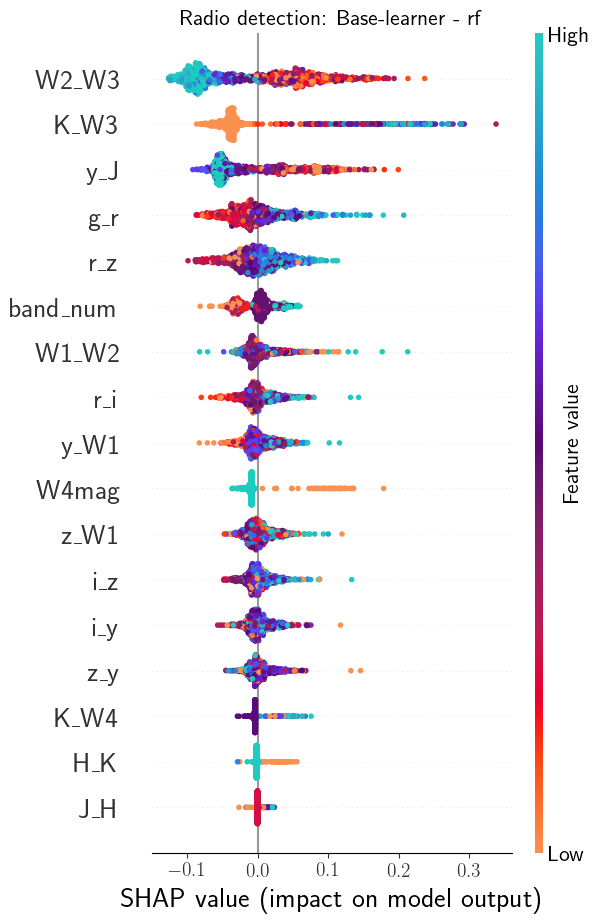

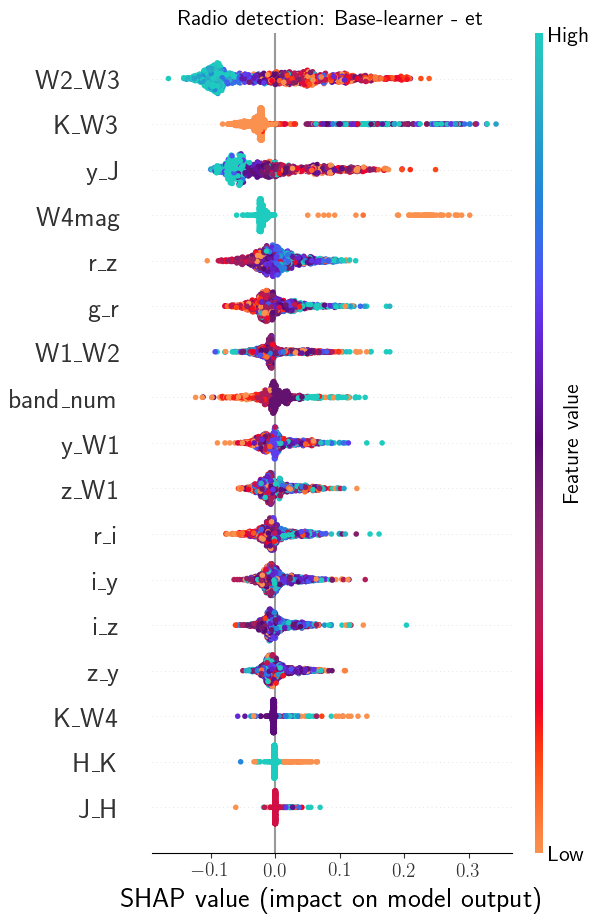

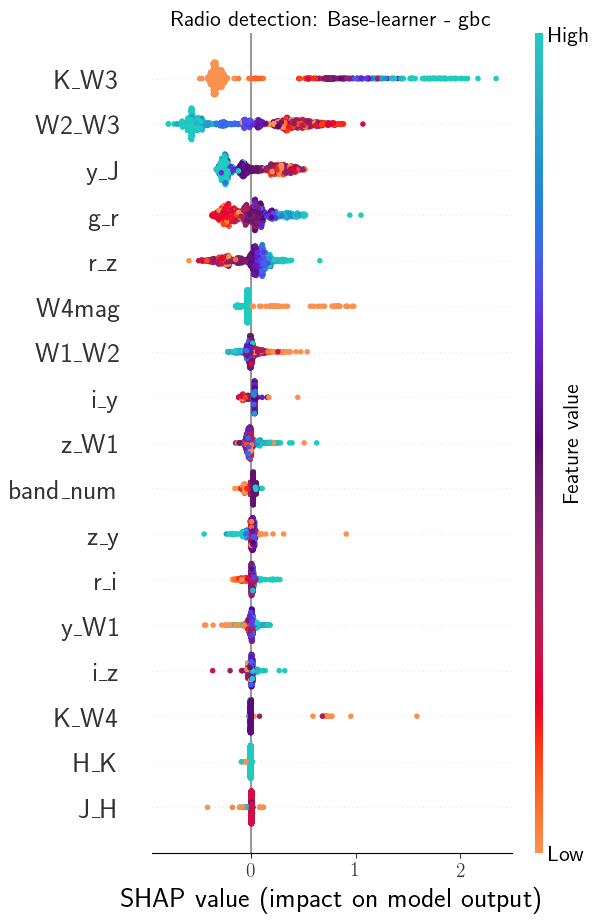

In [52]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        gf.plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_radio_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [53]:
# new_base_logit_radio = np.log(gv.radio_thresh / (1 - gv.radio_thresh))
new_base_logit_radio = np.log(0.5 / (1 - 0.5))

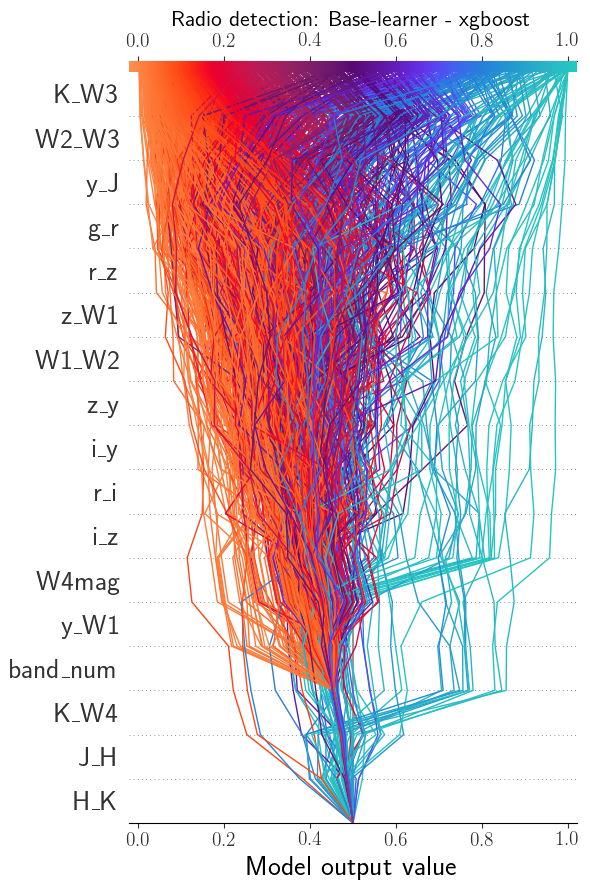

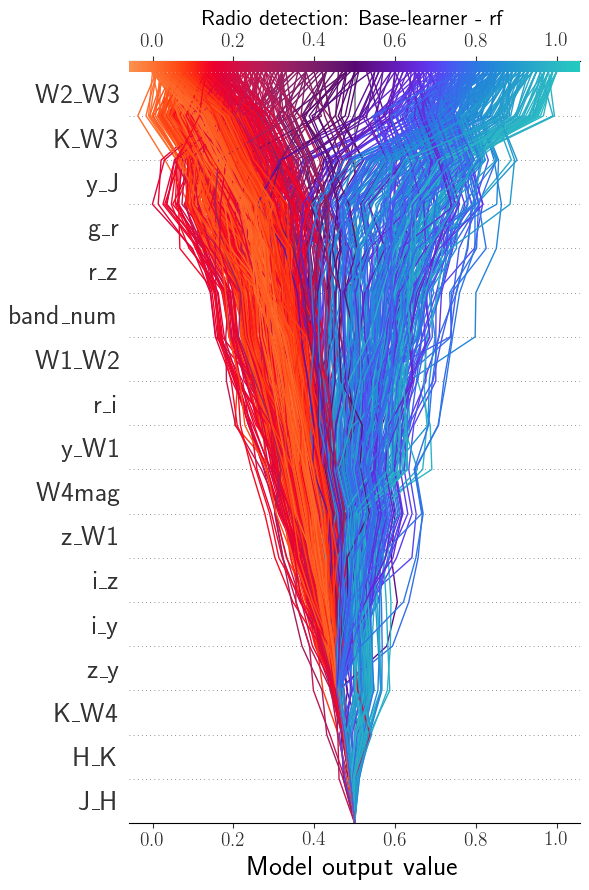

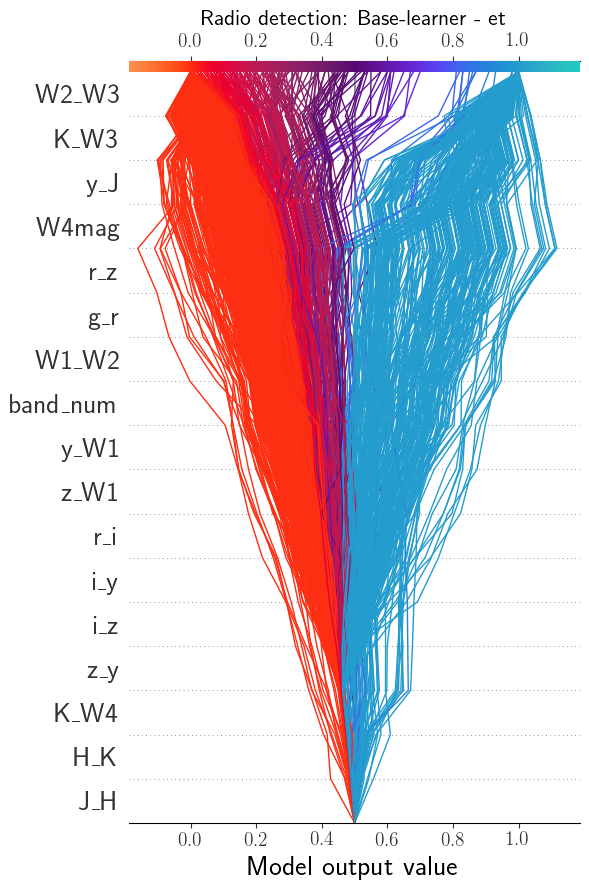

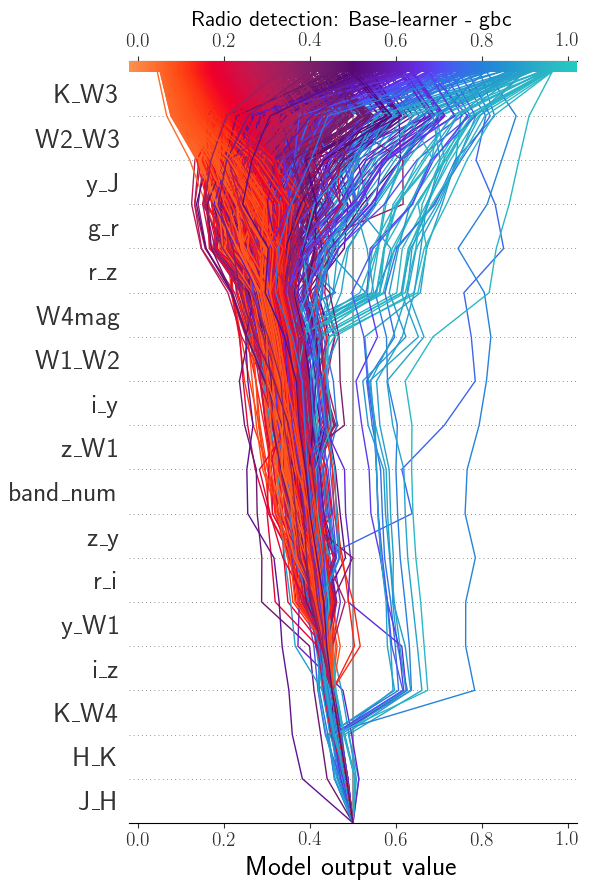

In [54]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        size_side          = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode     = 'logit'
            new_base_radio = new_base_logit_radio
        else:
            logit_mode     = 'identity'
            # new_base_radio = gv.radio_thresh
            new_base_radio = 0.5
        fig                = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Radio detection', model, shap_values_radio_base[model], explainers_radio_base[model],\
                                  reduced_cols_radio, ax1, logit_mode, new_base_value=new_base_radio, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_radio_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [55]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio = gf.mean_abs_SHAP_base_models(shap_values_radio_base, list(shap_values_radio_base.keys()))
    for key in shap_values_radio_base.keys():
        sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                  sorted_mean_abs_SHAP_radio[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_radio = [(key, name) for key in sorted_mean_abs_SHAP_radio.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [56]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio_base_full_df = pd.concat([sorted_mean_abs_SHAP_radio[key].reset_index(drop=True) for key in shap_values_radio_base.keys()], axis=1)
    sorted_mean_abs_SHAP_radio_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_radio)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_base_full_df)

Mean absolute SHAP values scaled to sum 100


xgboost                      rf                      et                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0       K_W3        19.333     W2_W3        18.190     W2_W3        17.008   
1      W2_W3        16.675      K_W3        17.157      K_W3        12.627   
2        y_J        10.973       y_J        13.369       y_J        12.388   
3        g_r         9.318       g_r         7.908     W4mag         7.165   
4        r_z         6.579       r_z         6.599       r_z         6.071   
5       z_W1         4.820  band_num         4.536       g_r         5.967   
6      W1_W2         4.673     W1_W2         4.252     W1_W2         5.413   
7        z_y         4.507       r_i         4.203  band_num         5.007   
8        i_y         4.496      y_W1         4.020      y_W1         4.862   
9        r_i         4.150     W4mag         3.798      z_W1         4.694   
10       i_z         3.686      z_W1         3.546       r_i         4.622   
11     W4mag         3.321       i_z         3.372       i_y         4.151   
12      y_W1         3.103       i_y         3.260       i_z         4.004   
13  band_num         2.185       z_y         2.995       z_y         3.603   
14      K_W4         1.345      K_W4         1.669      K_W4         1.274   
15       J_H         0.470       H_K         0.862       H_K         0.761   
16       H_K         0.365       J_H         0.265       J_H         0.383   

         gbc                
     Feature Mean_abs_SHAP  
0       K_W3        27.075  
1      W2_W3        23.350  
2        y_J        12.542  
3        g_r         9.456  
4        r_z         7.711  
5      W4mag         4.021  
6      W1_W2         2.626  
7        i_y         2.221  
8       z_W1         2.062  
9   band_num         1.663  
10       z_y         1.643  
11       r_i         1.639  
12      y_W1         1.588  
13       i_z         0.900  
14      K_W4         0.879  
15       H_K         0.379  
16       J_H         0.244

In [57]:
if run_shap_radio_base:
    sorted_mean_abs_SHAP_radio = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_radio_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [98]:
if run_shap_radio_base:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio.copy().set_index('Feature')
    for key in shap_values_radio_base.keys():
        factor = sorted_mean_abs_SHAP_radio.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_radio_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_radio_comb = sorted_mean_abs_SHAP_radio_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                                  ascending=False).drop(index=list(shap_values_radio_base.keys()))
    sorted_mean_abs_SHAP_radio_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_radio_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_radio_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                                
K_W3             19.202          19.202
W2_W3            17.420          36.623
y_J              11.491          48.114
g_r               8.591          56.704
r_z               6.419          63.123
W4mag             4.891          68.014
W1_W2             4.452          72.466
z_W1              3.831          76.297
r_i               3.755          80.051
i_y               3.697          83.748
y_W1              3.642          87.390
band_num          3.586          90.976
z_y               3.324          94.300
i_z               2.995          97.294
K_W4              1.555          98.850
H_K               0.705          99.554
J_H               0.446         100.000

xgboost


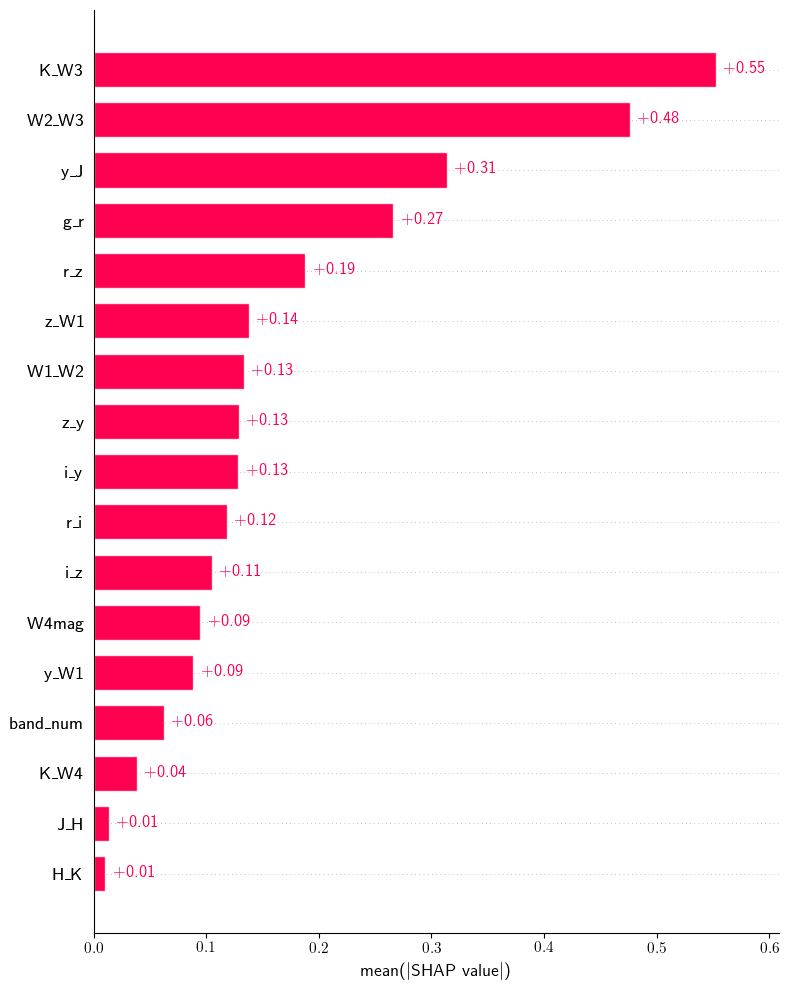

rf


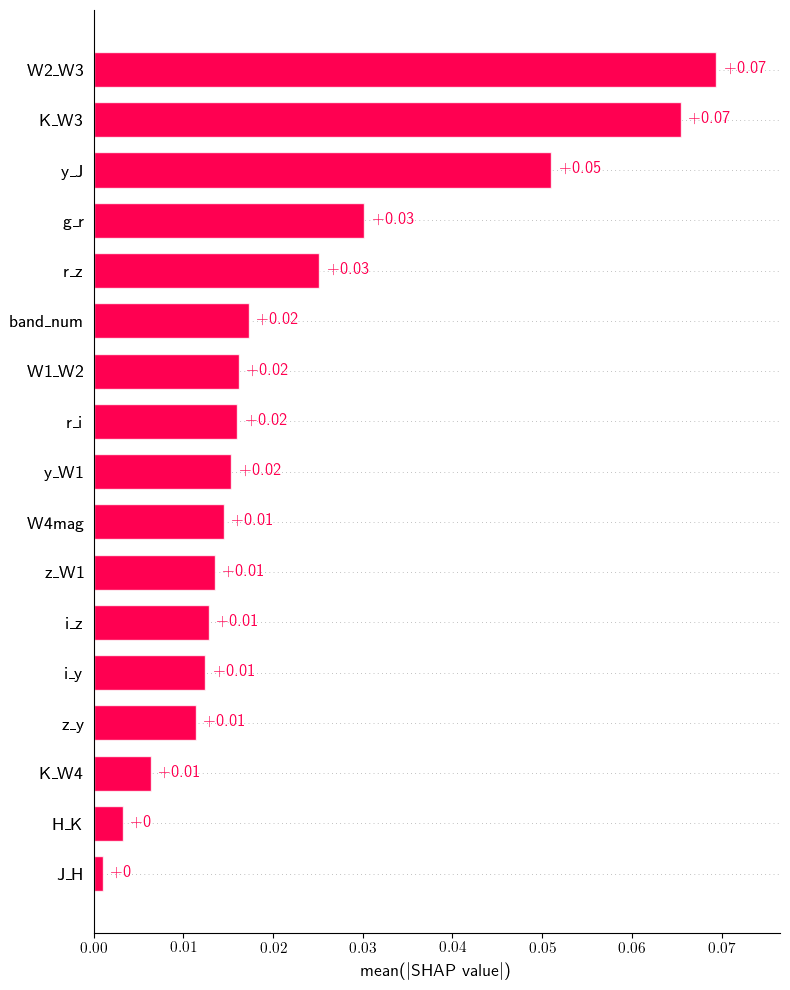

et


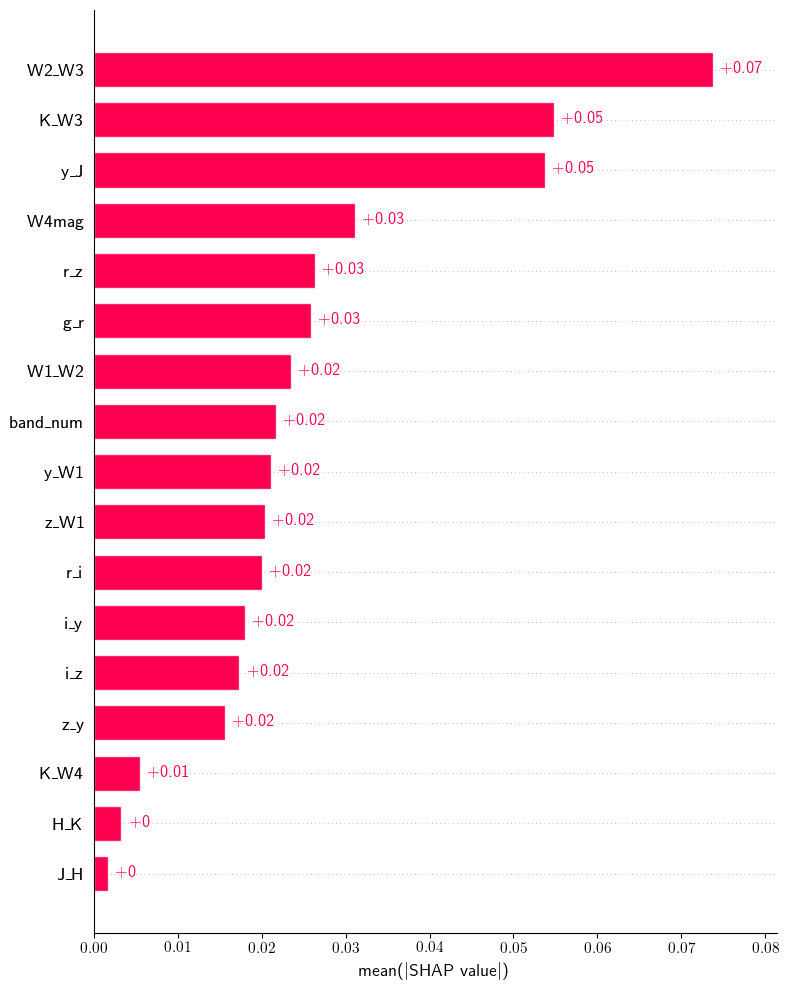

gbc


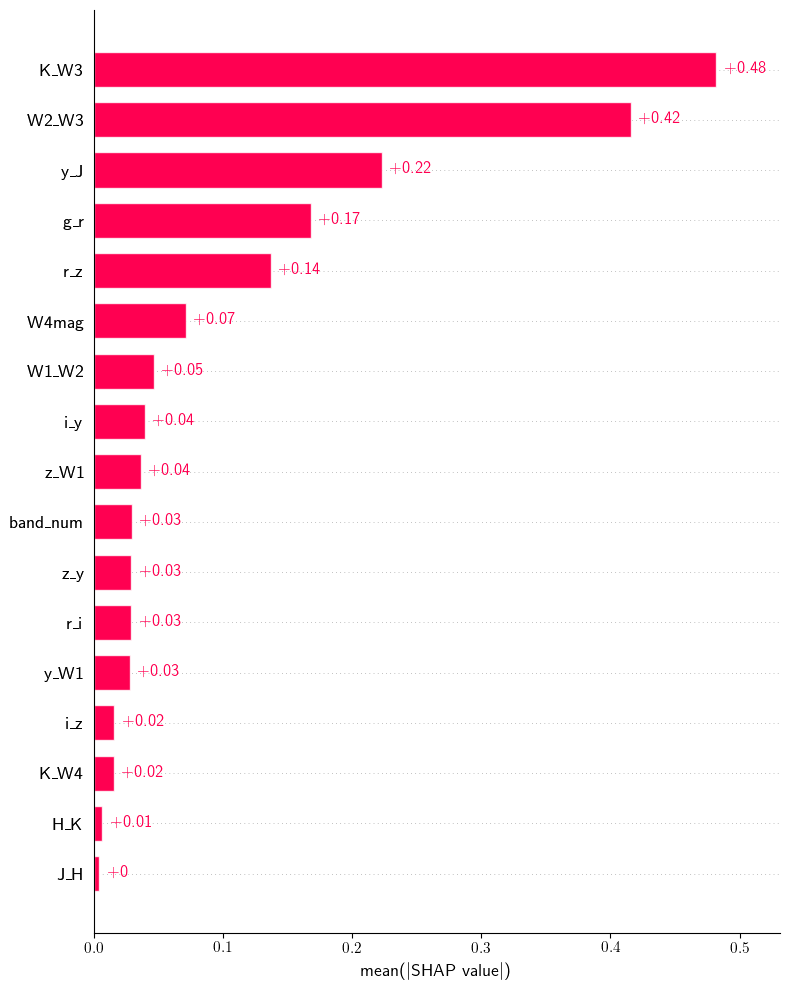

In [95]:
if run_shap_radio_base:
    shp_copies_radio = {}
    for model in shap_values_radio_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_radio[model] = shap.Explanation(values=shap_values_radio_base[model].values,\
                                                 base_values=shap_values_radio_base[model].base_values,\
                                                 data=shap_values_radio_base[model].data,\
                                                 feature_names=shap_values_radio_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_radio[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_radio[model], max_display=None, show=False)
        elif np.ndim(shp_copies_radio[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_radio[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

xgboost


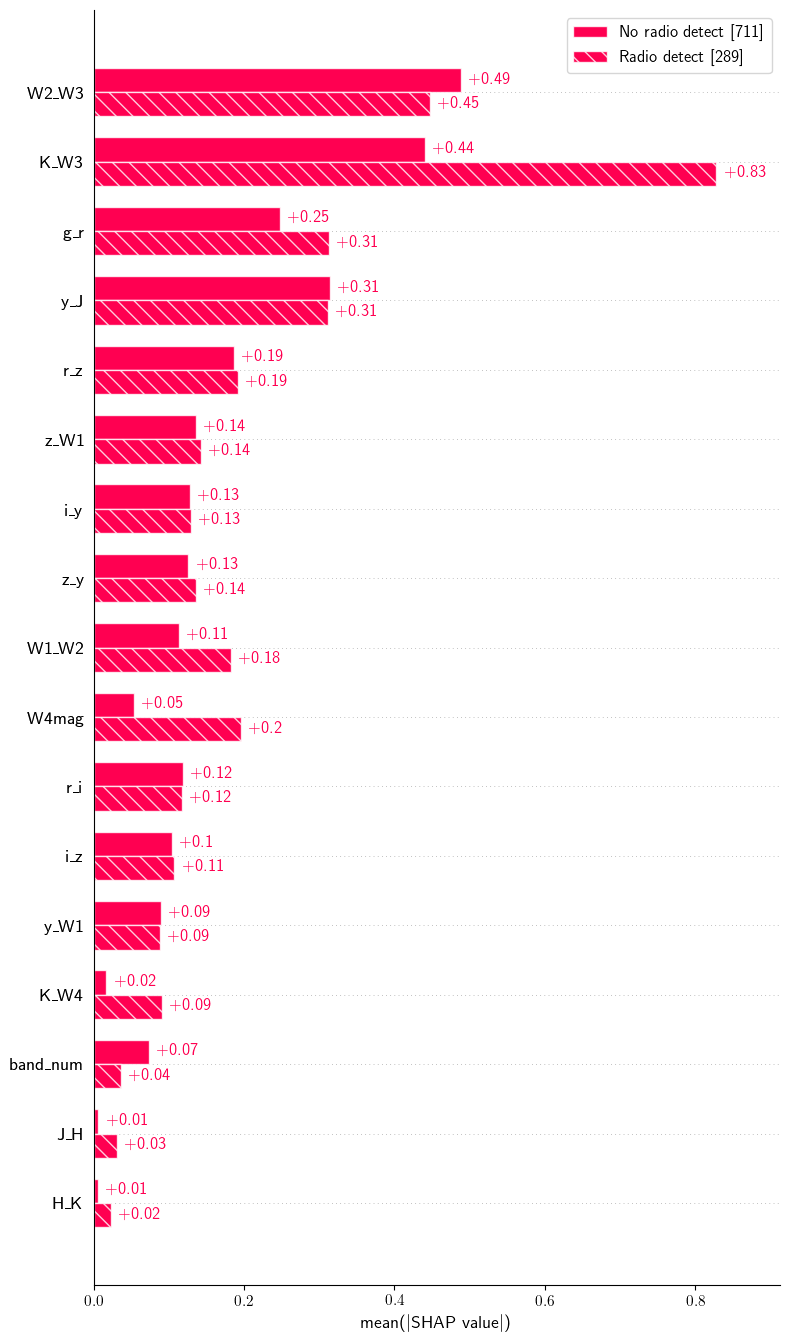

rf


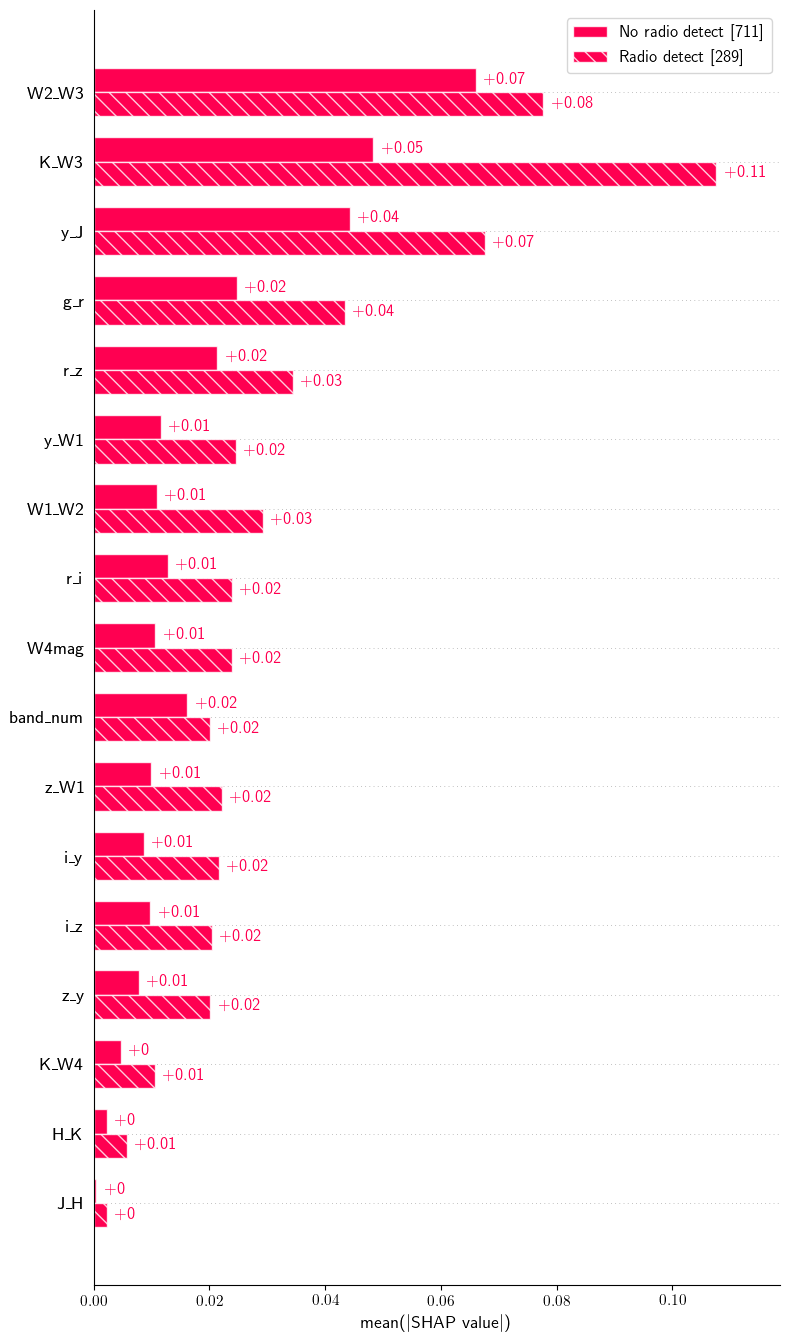

et


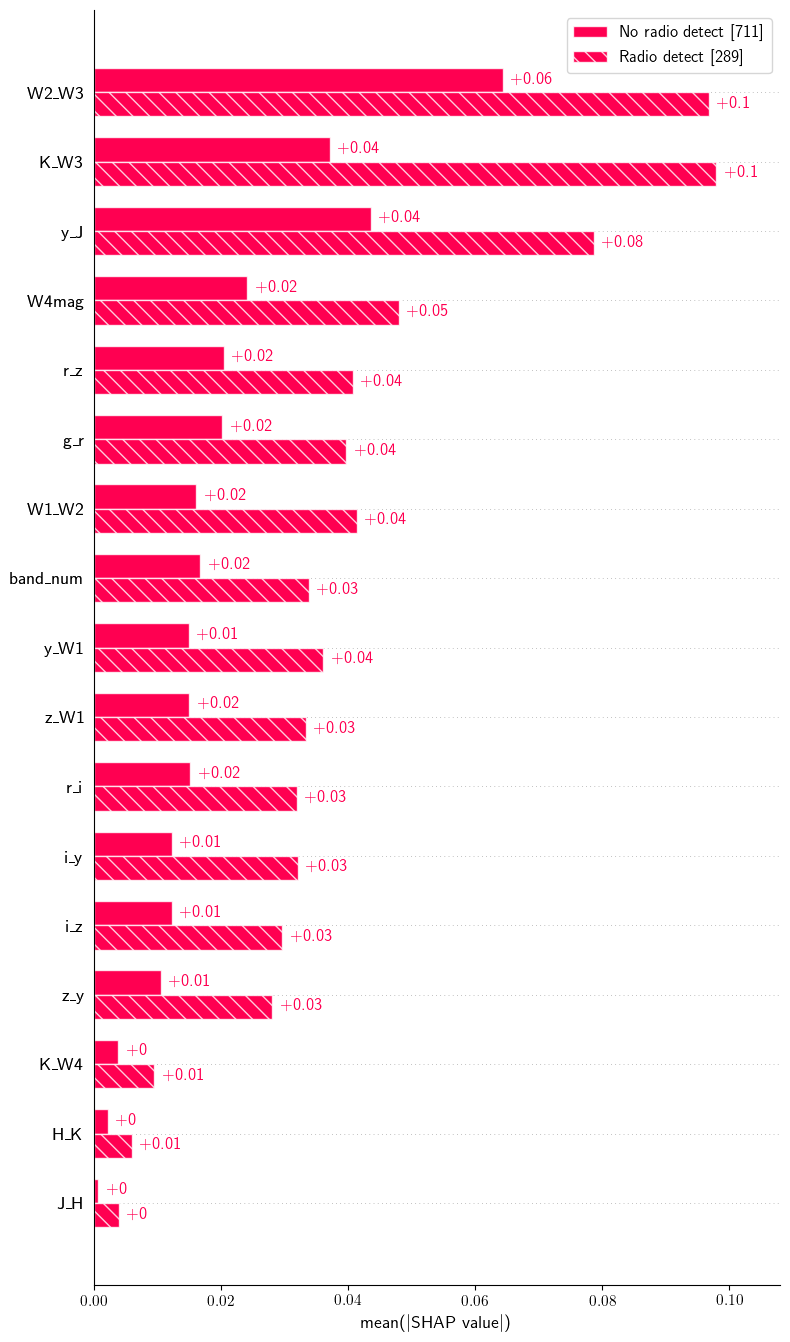

gbc


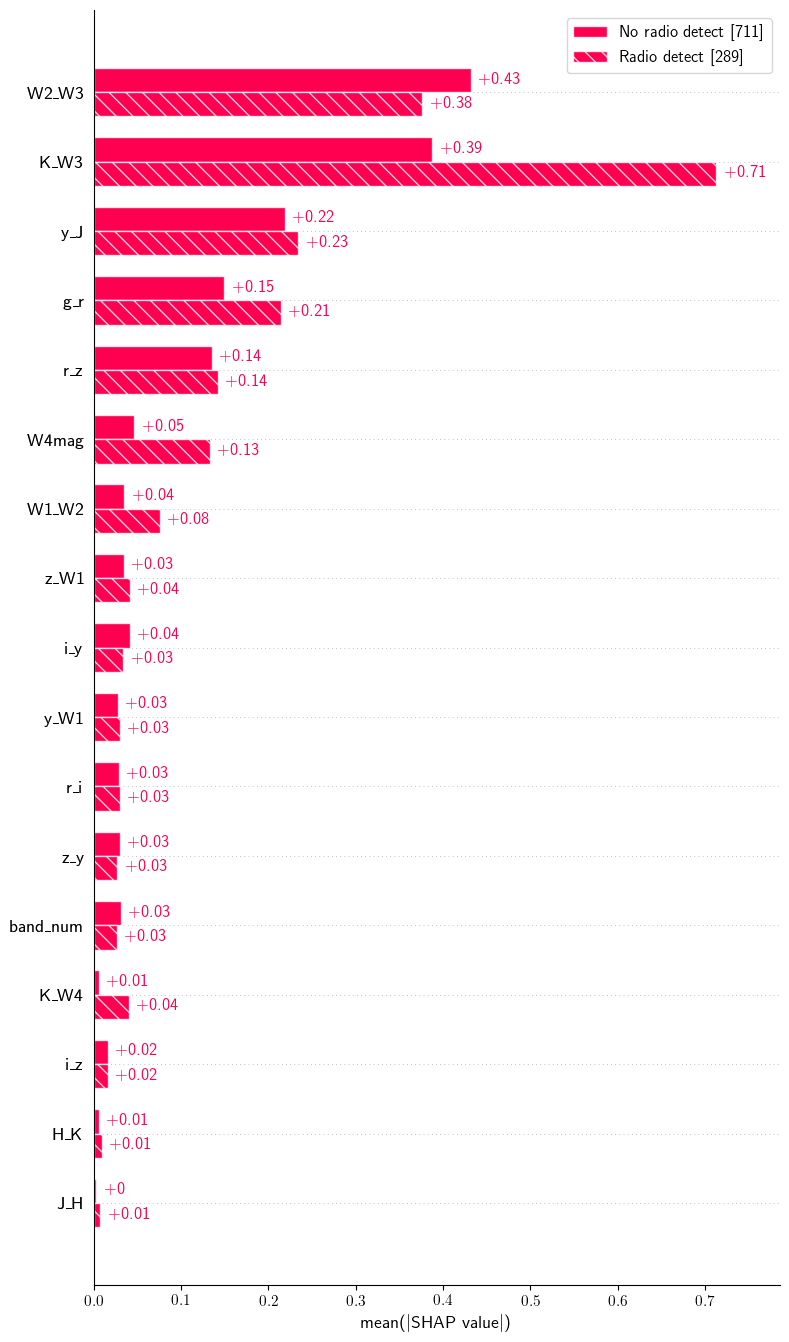

In [60]:
if run_shap_radio_base:
    radio_labels = ['No radio detect' if elem == 0 else 'Radio detect' for elem in reduced_data_radio.loc[:, 'LOFAR_detect']]
    for model in shap_values_radio_base.keys():
        print(f'{model}')
        if np.ndim(shp_copies_radio[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_radio[model].cohorts(radio_labels).abs.mean(0), max_display=None, show=False)
        elif np.ndim(shp_copies_radio[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_radio[model][:, :, 1].cohorts(radio_labels).abs.mean(0), max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [61]:
if run_shap_radio_base:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=base_models_name_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_radio_base[model].expected_value]).flatten()[-1] + shap_values_radio_base[model].values[0].sum()).round(5))


xgboost:
0
-0.16179

rf:
0
0.29899

et:
0
0.29921

gbc:
1
0.26797


---

#### SHAP - First redshift prediction model

In [62]:
if run_shap_z_base:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [63]:
if run_shap_z_base:
    sample_size_z        = 1000
    if use_high_z_sources:
        filter_pred_rAGN = np.ones_like(full_catalog_df.loc[:, 'pred_radio_AGN']).astype(bool)
    elif not use_high_z_sources:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z        = np.nanmin([sample_size_z, np.sum(filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 1,000


In [64]:
if run_shap_z_base:
    base_models_name_z = gf.get_base_estimators_names(redshift_reg)

In [65]:
if run_shap_z_base:
    reduced_data_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_z, random_state=gv.seed).copy()
    display(reduced_data_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_name_z)
    reduced_cols_z    = reduced_data_z_df.columns.drop(base_models_name_z)

Z       pred_Z
count  1000.000000  1000.000000
mean      1.532507     1.744133
std       0.763186     0.745746
min       0.000000     0.038000
25%       0.971750     1.234500
50%       1.529500     1.783500
75%       2.077500     2.338250
max       4.050000     3.699000

Use FastTreeSHAP package

In [66]:
if run_shap_z_base:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                 n_jobs=12)

In [67]:
if run_shap_z_base:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=base_models_name_z))

Working with base model et
Working with base model catboost
Working with base model xgboost
Working with base model gbr


In [68]:
if run_shap_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
et        	:  1.3095
catboost  	:  1.3093
xgboost   	:  1.3095
gbr       	:  1.3095


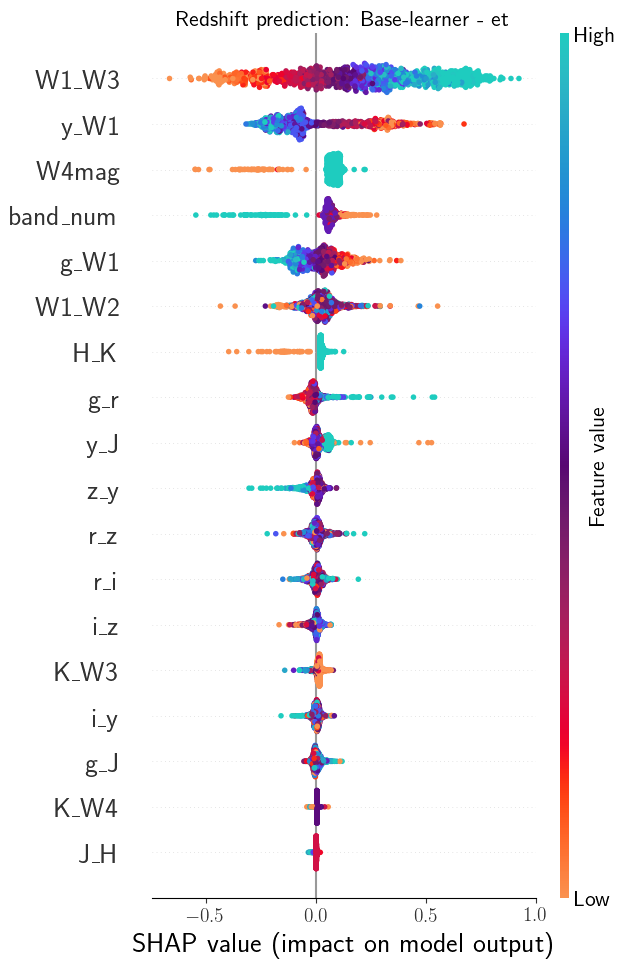

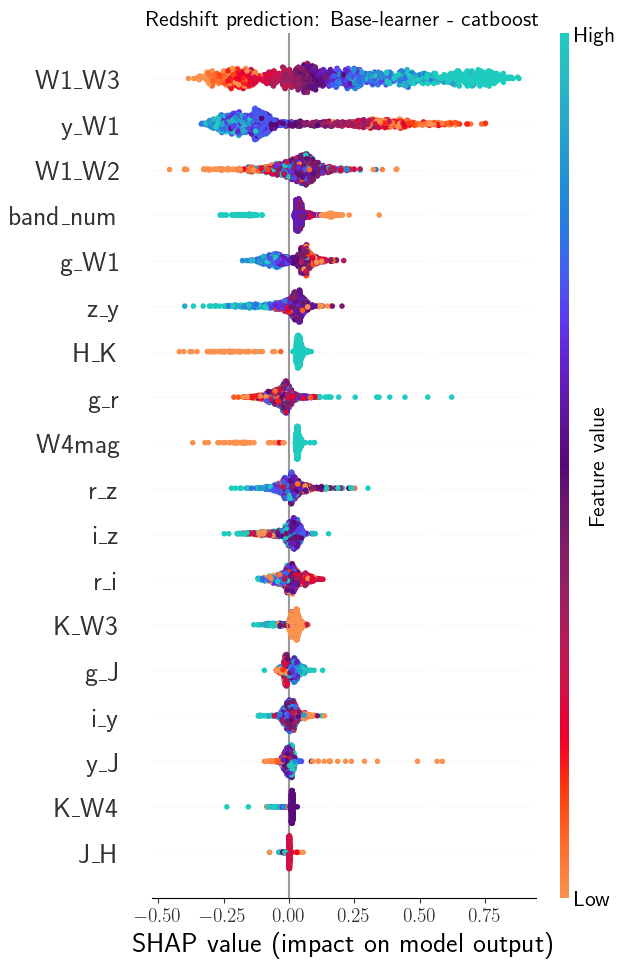

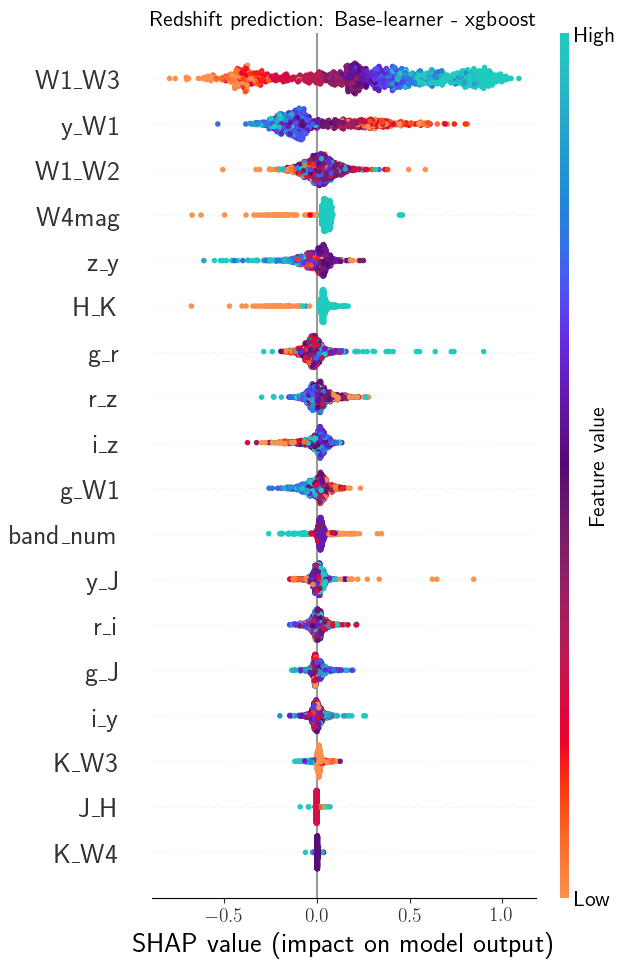

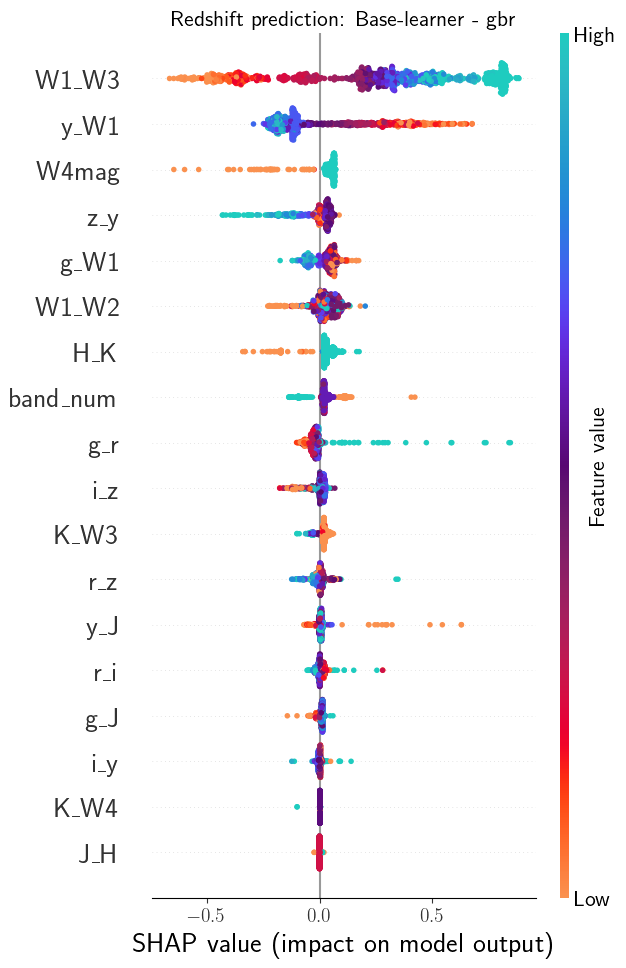

In [69]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        gf.plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

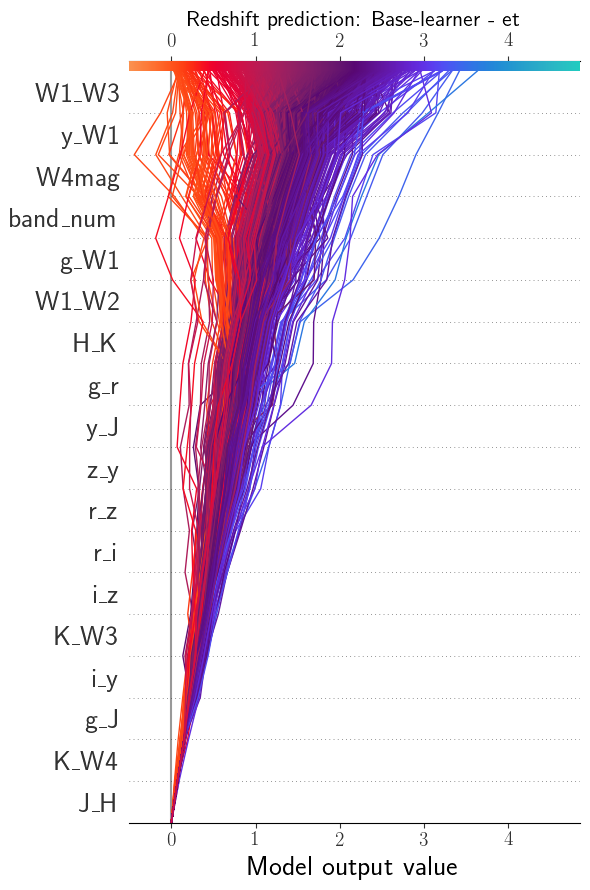

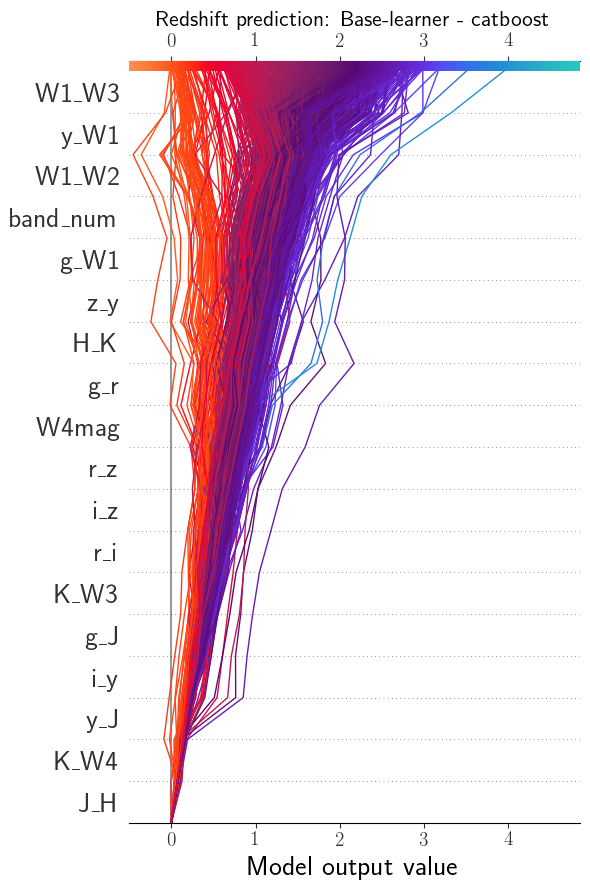

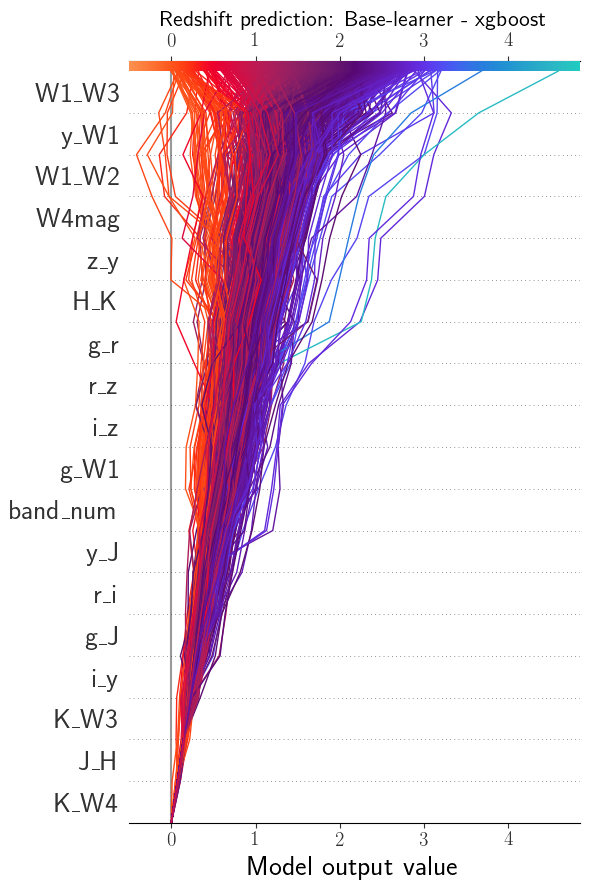

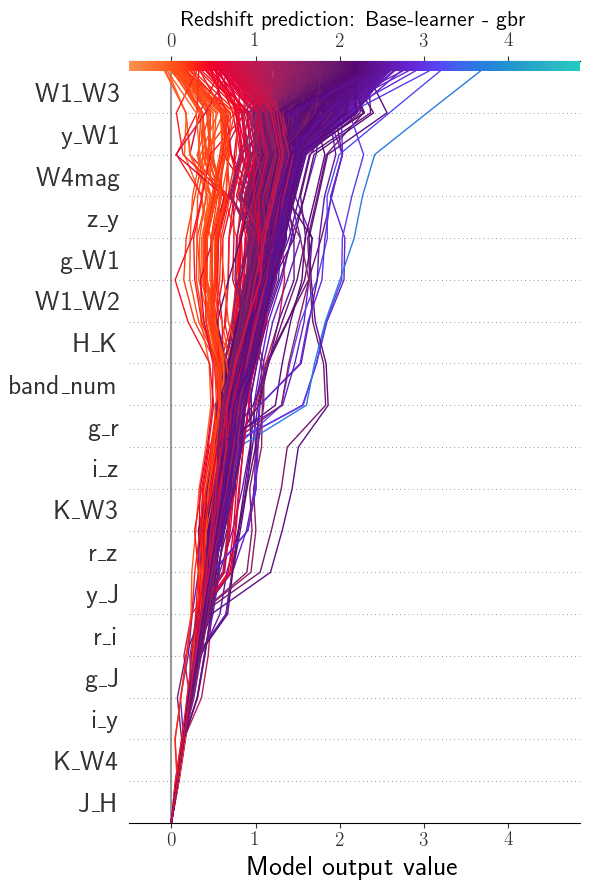

In [70]:
if run_shap_z_base:
    xlims_plt_z         = (-0.5, full_catalog_df.loc[reduced_data_z_df.index, ['Z', 'pred_Z']].max().max() + 0.8)
    for model in shap_values_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model],\
                                  reduced_cols_z, ax1, 'identity', new_base_value=0.0, base_meta='Base', xlim=xlims_plt_z)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [71]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z = gf.mean_abs_SHAP_base_models(shap_values_z_base, list(shap_values_z_base.keys()))
    for key in shap_values_z_base.keys():
        sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'] /\
                                                              sorted_mean_abs_SHAP_z[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_z = [(key, name) for key in sorted_mean_abs_SHAP_z.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [72]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z_base_full_df = pd.concat([sorted_mean_abs_SHAP_z[key].reset_index(drop=True) for key in shap_values_z_base.keys()], axis=1)
    sorted_mean_abs_SHAP_z_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_z)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_base_full_df)

Mean absolute SHAP values scaled to sum 100


et                catboost                 xgboost                \
     Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   Feature Mean_abs_SHAP   
0      W1_W3        31.153     W1_W3        27.298     W1_W3        36.780   
1       y_W1        17.132      y_W1        19.659      y_W1        15.432   
2      W4mag         9.016     W1_W2         6.840     W1_W2         5.591   
3   band_num         8.295  band_num         5.622     W4mag         4.976   
4       g_W1         7.383      g_W1         5.606       z_y         4.853   
5      W1_W2         5.578       z_y         4.618       H_K         4.203   
6        H_K         3.110       H_K         4.407       g_r         4.122   
7        g_r         2.904       g_r         3.846       r_z         3.744   
8        y_J         2.711     W4mag         3.732       i_z         3.576   
9        z_y         2.250       r_z         3.282      g_W1         3.562   
10       r_z         2.233       i_z         3.141  band_num         2.764   
11       r_i         1.950       r_i         2.933       y_J         2.306   
12       i_z         1.613      K_W3         2.459       r_i         2.251   
13      K_W3         1.554       g_J         1.849       g_J         1.938   
14       i_y         1.224       i_y         1.828       i_y         1.893   
15       g_J         1.207       y_J         1.435      K_W3         1.557   
16      K_W4         0.501      K_W4         1.184       J_H         0.232   
17       J_H         0.188       J_H         0.262      K_W4         0.221   

         gbr                
     Feature Mean_abs_SHAP  
0      W1_W3        39.953  
1       y_W1        19.439  
2      W4mag         5.754  
3        z_y         4.720  
4       g_W1         4.618  
5      W1_W2         4.333  
6        H_K         4.194  
7   band_num         3.584  
8        g_r         3.229  
9        i_z         2.297  
10      K_W3         2.155  
11       r_z         1.646  
12       y_J         1.291  
13       r_i         1.069  
14       g_J         1.016  
15       i_y         0.487  
16      K_W4         0.175  
17       J_H         0.040

In [73]:
if run_shap_z_base:
    sorted_mean_abs_SHAP_z = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [100]:
if run_shap_z_base:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z.copy().set_index('Feature')
    for key in shap_values_z_base.keys():
        factor = sorted_mean_abs_SHAP_z.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_z_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_z_comb = sorted_mean_abs_SHAP_z_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                              ascending=False).drop(index=list(shap_values_z_base.keys()))
    sorted_mean_abs_SHAP_z_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_z_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_z_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                                
W1_W3            32.430          32.430
y_W1             15.655          48.085
H_K               6.499          54.584
band_num          5.737          60.320
W1_W2             5.549          65.870
g_W1              4.732          70.601
W4mag             4.613          75.214
z_y               4.206          79.420
g_r               3.930          83.350
i_z               3.366          86.716
r_z               3.004          89.720
r_i               2.707          92.427
y_J               1.966          94.393
K_W3              1.732          96.125
i_y               1.570          97.694
g_J               1.510          99.205
K_W4              0.453          99.658
J_H               0.342         100.000

et


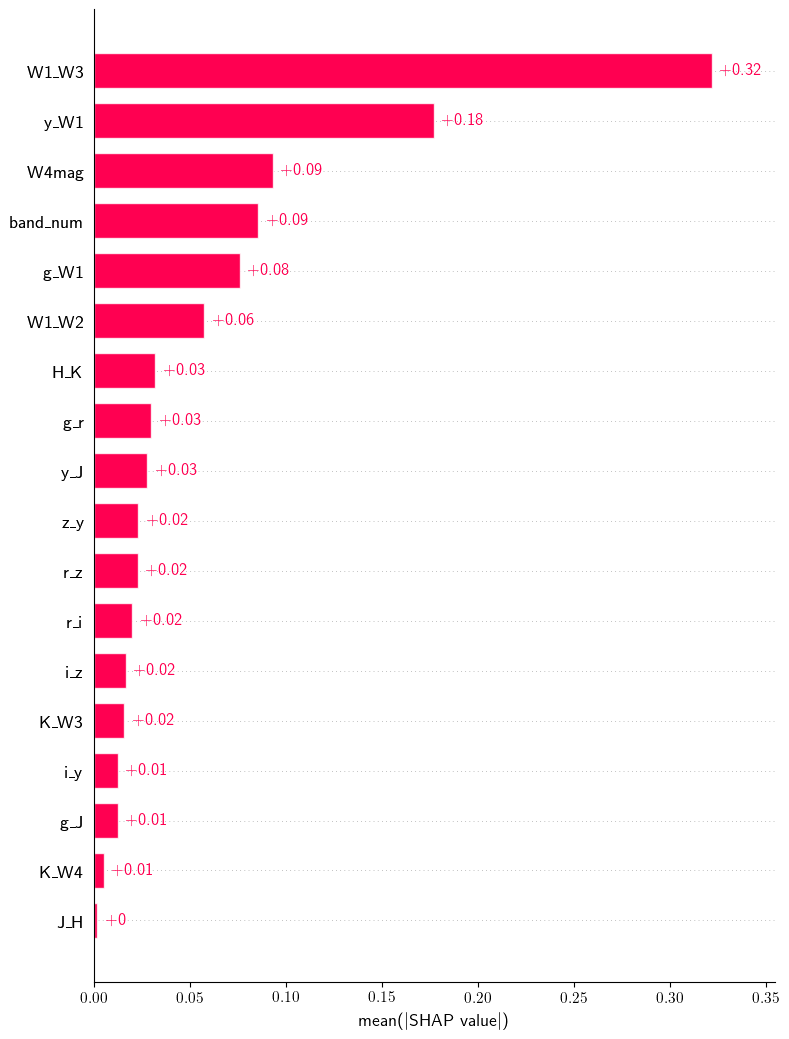

catboost


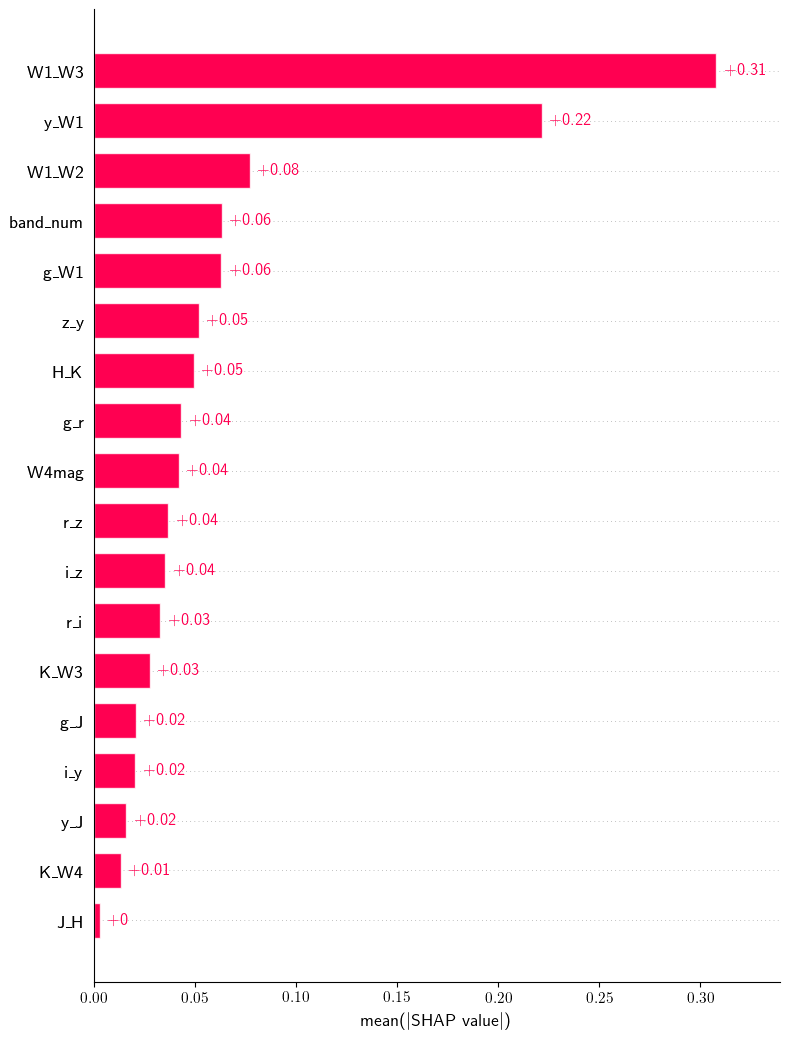

xgboost


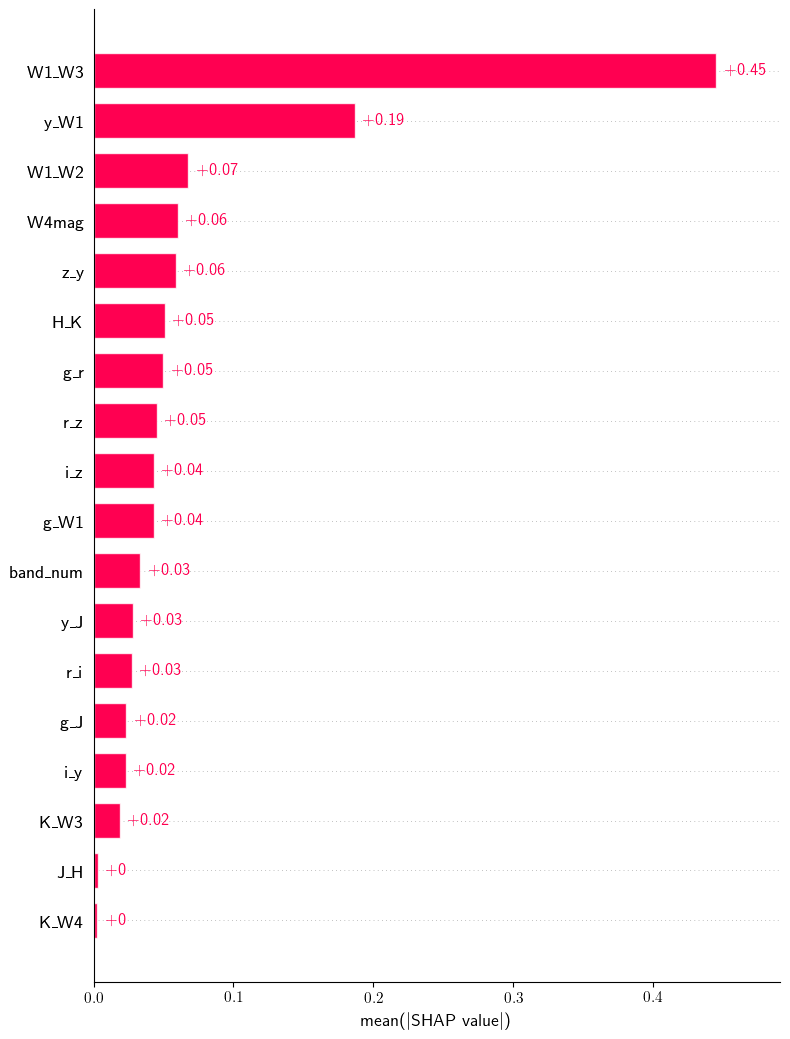

gbr


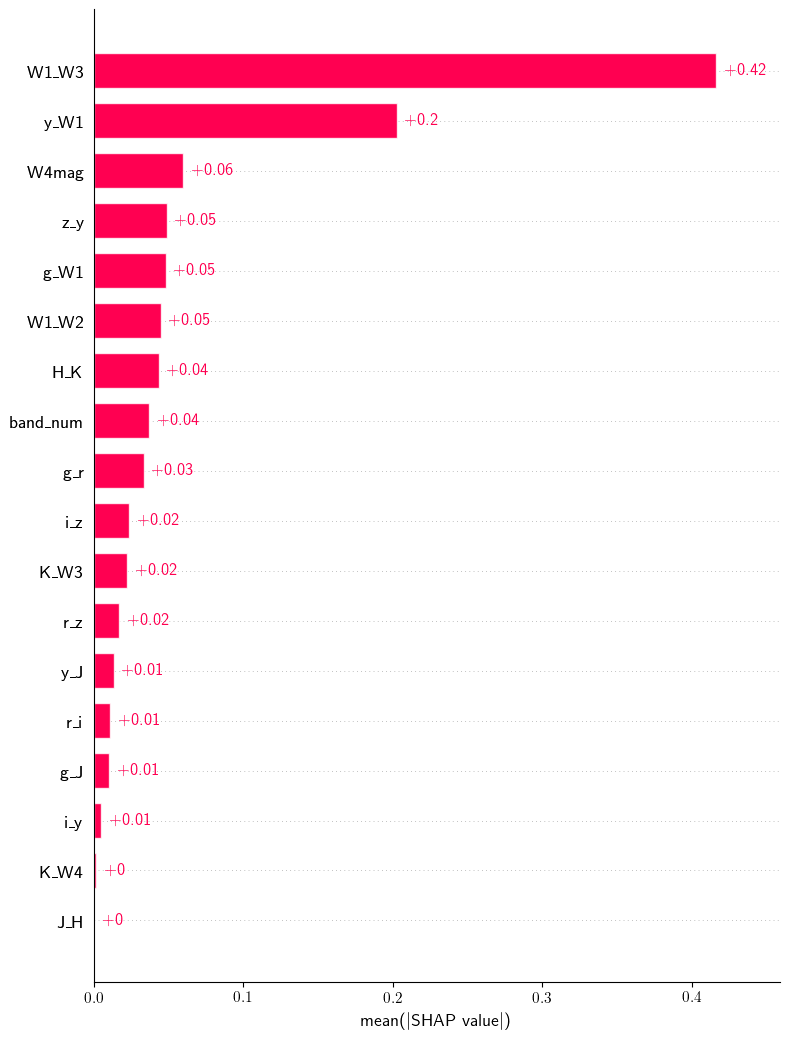

In [75]:
if run_shap_z_base:
    shp_copies_z = {}
    for model in shap_values_z_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_z[model] = shap.Explanation(values=shap_values_z_base[model].values,\
                                               base_values=shap_values_z_base[model].base_values,\
                                               data=shap_values_z_base[model].data,\
                                               feature_names=shap_values_z_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_z[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_z[model], max_display=None, show=False)
        elif np.ndim(shp_copies_z[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_z[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [76]:
if run_shap_z_base:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=base_models_name_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))


et:
1.32729
1.32729

catboost:
1.31717
1.31717

xgboost:
1.39312
1.39312

gbr:
1.51767
1.51767


---

#### SHAP - Second redshift prediction model

In [77]:
if not use_second_z_model: run_shap_high_z_meta = False

In [78]:
if run_shap_high_z_base & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [79]:
if run_shap_high_z_base & use_second_z_model:
    sample_size_high_z          = 1000
    if use_high_z_sources:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)
    elif not use_high_z_sources:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    sample_size_high_z          = np.nanmin([sample_size_high_z, np.sum(filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

Number of selected elements: 956


In [80]:
if run_shap_high_z_base & use_second_z_model:
    base_models_name_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [81]:
if run_shap_high_z_base & use_second_z_model:
    reduced_data_high_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_high_z, random_state=gv.seed).copy()
    display(reduced_data_high_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_high_z_df = gf.preprocess_data(redshift_reg_2, reduced_data_high_z, base_models_name_high_z)
    reduced_cols_high_z    = reduced_data_high_z_df.columns.drop(base_models_name_high_z)

Z      pred_Z
count  956.000000  956.000000
mean     1.534761    1.737407
std      0.769689    0.747027
min      0.000000    0.038000
25%      0.971750    1.234500
50%      1.529500    1.780000
75%      2.083500    2.330750
max      4.050000    3.699000

Use FastTreeSHAP package

In [82]:
if run_shap_high_z_base & use_second_z_model:
    explainers_high_z_base           = {}
    for model, model_fit in zip(redshift_reg_2.named_steps['trained_model'].estimators, redshift_reg_2.named_steps['trained_model'].estimators_):
        explainers_high_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                      model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                      n_jobs=12)

In [83]:
if run_shap_high_z_base & use_second_z_model:
    shap_values_high_z_base = {}
    for model in explainers_high_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_high_z_base[model] = explainers_high_z_base[model](reduced_data_high_z_df.drop(columns=base_models_name_high_z))

Working with base model catboost
Working with base model xgboost
Working with base model gbr
Working with base model rf


In [84]:
if run_shap_high_z_base & use_second_z_model:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_high_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
catboost  	:  2.5532
xgboost   	:  2.5532
gbr       	:  2.5532
rf        	:  2.5521


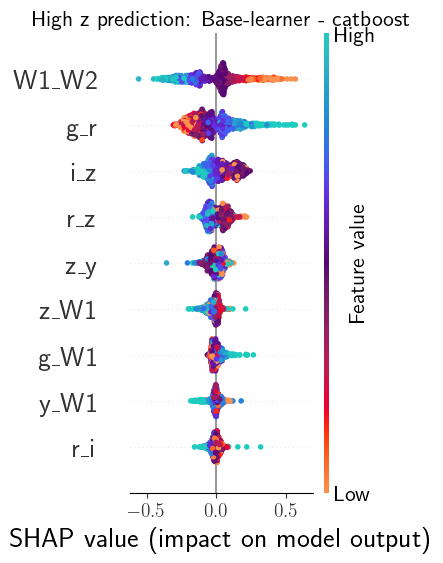

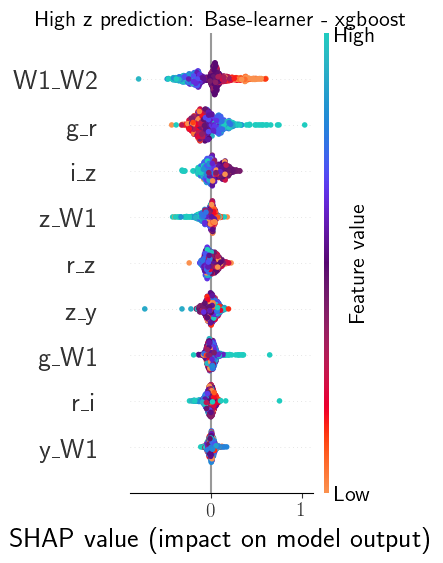

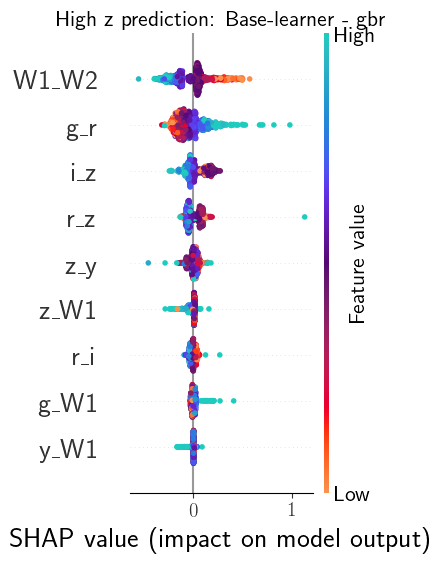

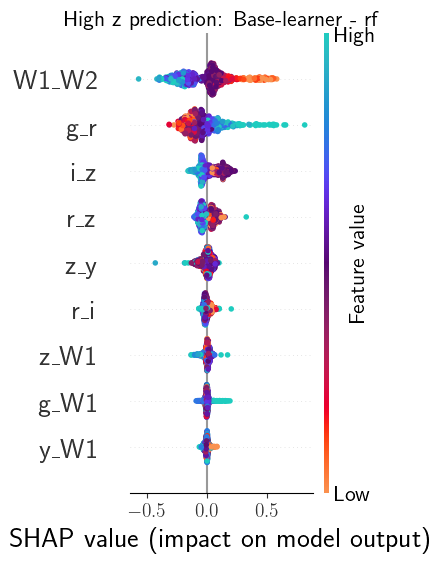

In [85]:
if run_shap_high_z_base & use_second_z_model:
    for model in shap_values_high_z_base.keys():
        gf.plot_shap_beeswarm('High z prediction', model, shap_values_high_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_high_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

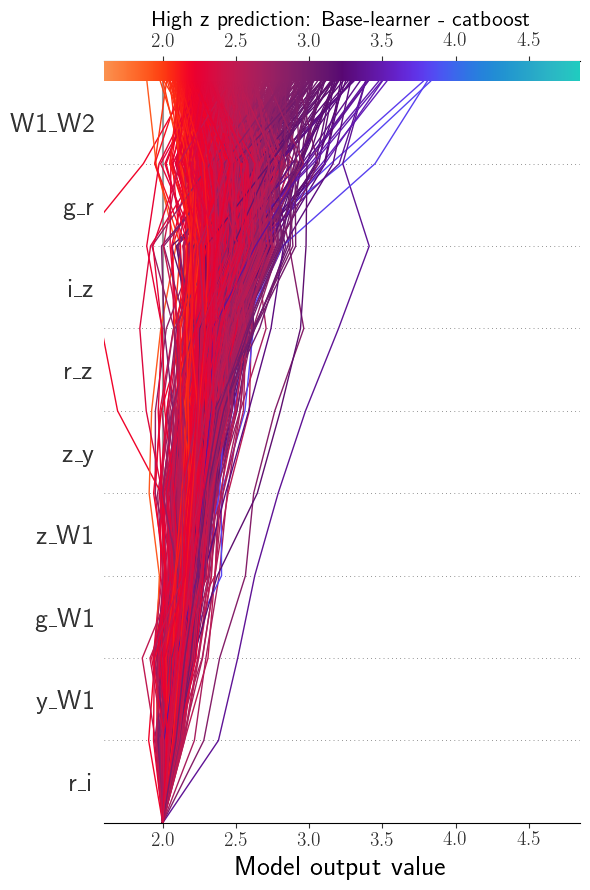

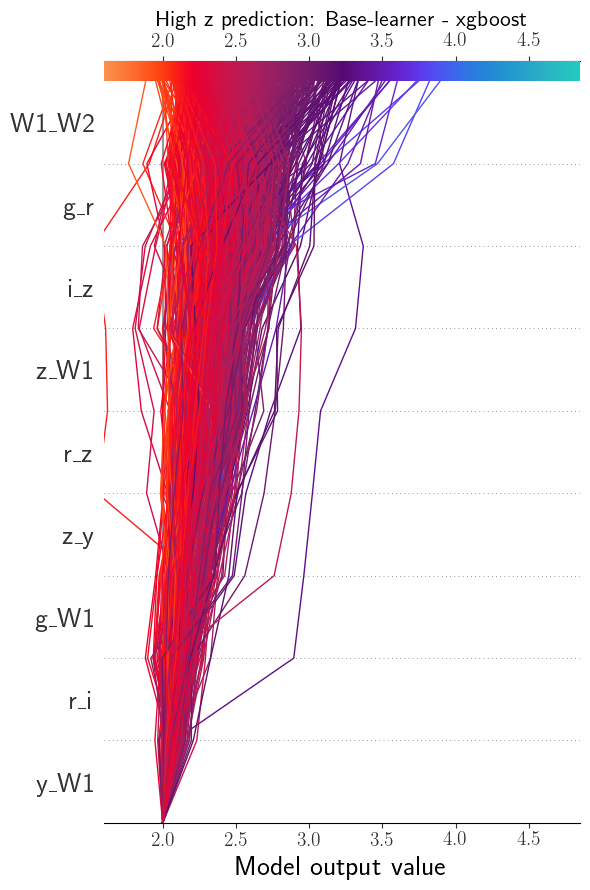

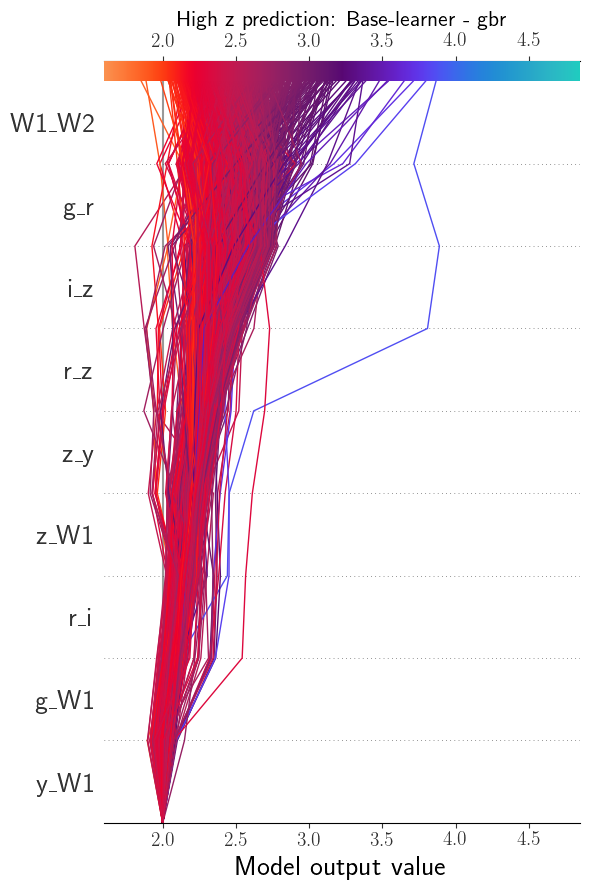

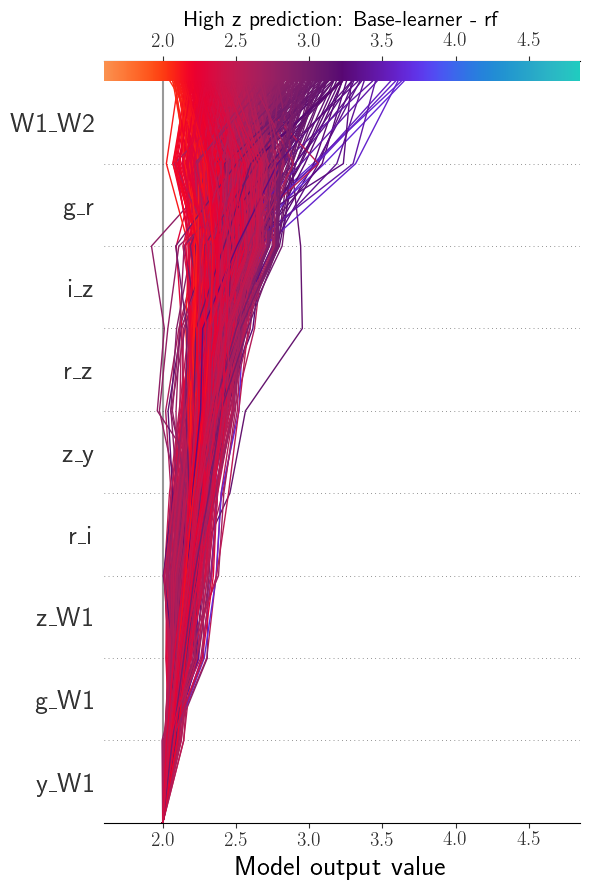

In [86]:
if run_shap_high_z_base & use_second_z_model:
    xlims_plt_hz    = (gv.high_z_limit - 0.4,\
                       full_catalog_df.loc[reduced_data_high_z_df.index, ['Z','pred_Z']].max().max() + 0.8)
    for model in shap_values_high_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('High z prediction', model, shap_values_high_z_base[model],\
                                  explainers_high_z_base[model], reduced_cols_high_z, ax1, 'identity',\
                                  new_base_value=gv.high_z_limit, base_meta='Base', xlim=xlims_plt_hz)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_high_z_base_{model}_{used_area}{subset_str}{high_z_str}.pdf', bbox_inches='tight')
        plt.show()

In [87]:
if run_shap_high_z_base & use_second_z_model:
    sorted_mean_abs_SHAP_high_z = gf.mean_abs_SHAP_base_models(shap_values_high_z_base, list(shap_values_high_z_base.keys()))
    for key in shap_values_high_z_base.keys():
        sorted_mean_abs_SHAP_high_z[key].loc[:, 'Mean_abs_SHAP'] = sorted_mean_abs_SHAP_high_z[key].loc[:, 'Mean_abs_SHAP'] /\
                                                                   sorted_mean_abs_SHAP_high_z[key].loc[:, 'Mean_abs_SHAP'].sum() * 100
    multicol_feat_high_z = [(key, name) for key in sorted_mean_abs_SHAP_high_z.keys() for name in ('Feature', 'Mean_abs_SHAP')]

In [88]:
if run_shap_high_z_base & use_second_z_model:
    sorted_mean_abs_SHAP_high_z_base_full_df = pd.concat([sorted_mean_abs_SHAP_high_z[key].reset_index(drop=True) for key in shap_values_high_z_base.keys()], axis=1)
    sorted_mean_abs_SHAP_high_z_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat_high_z)
    print('Mean absolute SHAP values scaled to sum 100')
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_high_z_base_full_df)

Mean absolute SHAP values scaled to sum 100


catboost               xgboost                   gbr                    rf  \
   Feature Mean_abs_SHAP Feature Mean_abs_SHAP Feature Mean_abs_SHAP Feature   
0    W1_W2        27.061   W1_W2        26.874   W1_W2        28.588   W1_W2   
1      g_r        22.857     g_r        19.415     g_r        22.767     g_r   
2      i_z        14.735     i_z        13.272     i_z        15.880     i_z   
3      r_z         9.861    z_W1         8.649     r_z        11.653     r_z   
4      z_y         6.327     r_z         8.208     z_y         6.020     z_y   
5     z_W1         5.243     z_y         7.816    z_W1         4.883     r_i   
6     g_W1         4.888    g_W1         5.973     r_i         4.257    z_W1   
7     y_W1         4.746     r_i         5.905    g_W1         3.287    g_W1   
8      r_i         4.281    y_W1         3.888    y_W1         2.665    y_W1   

                 
  Mean_abs_SHAP  
0        32.321  
1        23.048  
2        14.994  
3        10.131  
4         6.567  
5         4.203  
6         3.606  
7         2.667  
8         2.464

In [89]:
if run_shap_high_z_base & use_second_z_model:
    sorted_mean_abs_SHAP_high_z = pd.read_hdf(gv.tmp_shap_path + f'mean_abs_SHAP_high_z_meta_{used_area}{subset_str}{high_z_str}.h5', key='df')

In [101]:
if run_shap_high_z_base & use_second_z_model:
    print('Combined mean absolute SHAP values scaled to sum 100')
    sorted_mean_abs_SHAP_high_z_comb = sorted_mean_abs_SHAP_high_z.copy().set_index('Feature')
    for key in shap_values_high_z_base.keys():
        factor = sorted_mean_abs_SHAP_high_z.set_index('Feature').loc[key] / 100
        tmp_feat_imp = sorted_mean_abs_SHAP_high_z_base_full_df.loc[:, key].copy().set_index('Feature')
        sorted_mean_abs_SHAP_high_z_comb = sorted_mean_abs_SHAP_high_z_comb + tmp_feat_imp * factor
    sorted_mean_abs_SHAP_high_z_comb = sorted_mean_abs_SHAP_high_z_comb.sort_values(by=['Mean_abs_SHAP'],
                                                                              ascending=False).drop(index=list(shap_values_high_z_base.keys()))
    sorted_mean_abs_SHAP_high_z_comb['Cumulative_sum'] = sorted_mean_abs_SHAP_high_z_comb.loc[:, 'Mean_abs_SHAP'].cumsum()
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(sorted_mean_abs_SHAP_high_z_comb)

Combined mean absolute SHAP values scaled to sum 100


Mean_abs_SHAP  Cumulative_sum
Feature                               
W1_W2           27.527          27.527
g_r             21.662          49.189
i_z             13.930          63.119
r_z              9.729          72.847
z_y              6.871          79.718
z_W1             5.810          85.528
g_W1             5.413          90.941
r_i              4.854          95.795
y_W1             4.205         100.000

catboost


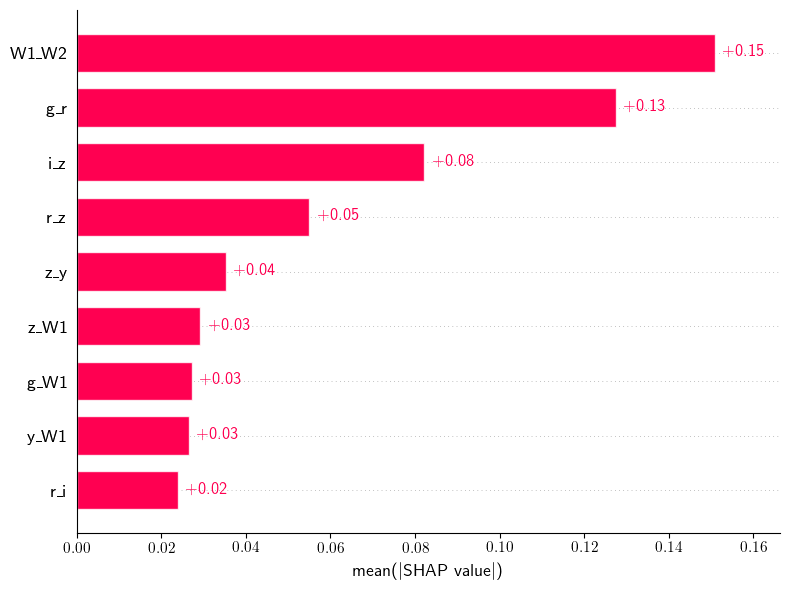

xgboost


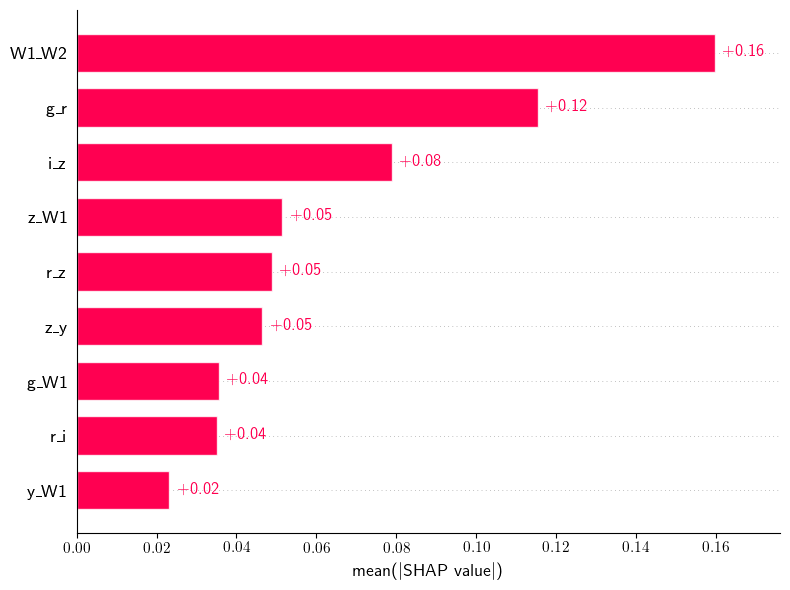

gbr


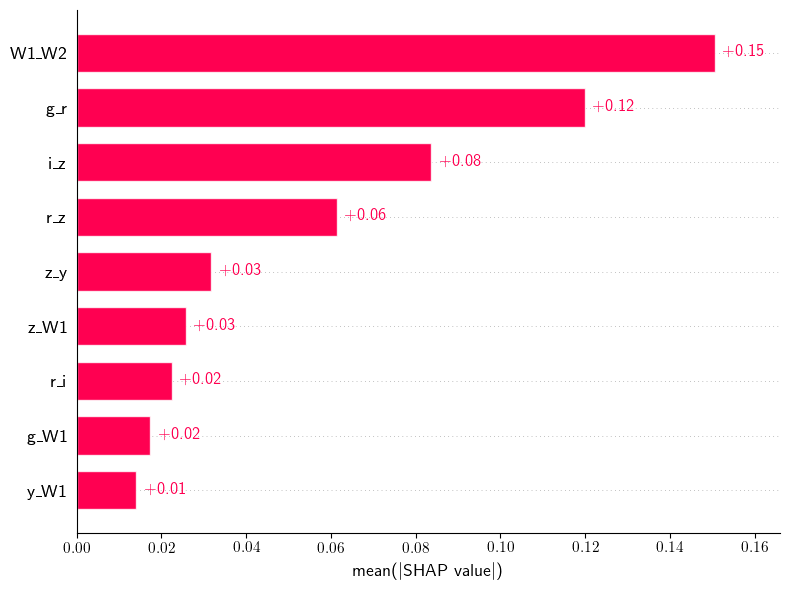

rf


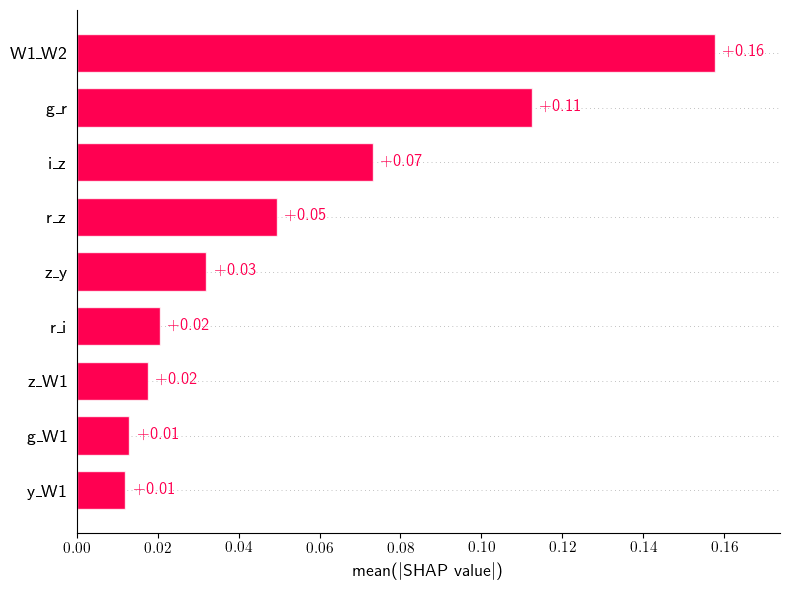

In [91]:
if run_shap_high_z_base & use_second_z_model:
    shp_copies_high_z = {}
    for model in shap_values_high_z_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_high_z[model] = shap.Explanation(values=shap_values_high_z_base[model].values,\
                                                    base_values=shap_values_high_z_base[model].base_values,\
                                                    data=shap_values_high_z_base[model].data,\
                                                    feature_names=shap_values_high_z_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_high_z[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_high_z[model], max_display=None, show=False)
        elif np.ndim(shp_copies_high_z[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_high_z[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [92]:
if run_shap_high_z_base & use_second_z_model:
    for count, model in enumerate(shap_values_high_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg_2.named_steps['trained_model'].estimators_[count].predict(reduced_data_high_z_df.drop(columns=base_models_name_high_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_high_z_base[model].expected_value[-1] + shap_values_high_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_high_z_base[model].expected_value + shap_values_high_z_base[model].values[0].sum()).round(5))


catboost:
2.28119
2.28119

xgboost:
2.14306
2.14307

gbr:
2.28896
2.28896

rf:
2.2919
2.2919
